# Time Series Analysis: Indonesia's Economic Analysis & Prediction
**Author**: Moch Nabil Farras Dhiya

**E-mail**: nabilfarras923@gmail.com

**Institution**: Bandung Institute of Technology

**Student ID**: 10120034


---

**About**: This is a side-project created in order to analyze whether there is a relationship between COVID-19, Currency Exchange, and Stock Market, especially in Indonesia. The steps are of the followings:


1.   Extracting data from External Sources (Yahoo Finance) and Local DB
2.   Transform the data (making sure it is usable and consistent)
3.   Analyze the data trend and statistical test to check the relationship between the data
4.   TSA forecasting to predict the economic condition

**Bonus**: Portfolio Optimization on BBCA.JK, ^JKSE will also be given.  

These steps will be automatically implemented on daily basis, so we only need to monitor the dashboard.

**NOTE**: In this project, I use on-site database in order to minimize the cost as Cloud Databases are mostly paid.

# Import Modules

In [1]:
# !pip install requests lxml html5lib beautifulsoup4 pandas_datareader \
# yfinance yahoofinancials seaborn pmdarima arch sqlalchemy pymysql keras

In [2]:
# Connect with local machine
import os

# Extracting file from URL (Online website)
import requests
from bs4 import BeautifulSoup

# Extract stock market data
import yfinance as yf
from yahoofinancials import YahooFinancials

# Importing and transforming file
import pandas as pd
import pandas_datareader as dr

# Data manipulation
import numpy as np
import re # Cleaning texts
import time
import datetime as dt # Datetime manipulation
from scipy.stats import pearsonr # Statistics

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Time Series Analysis
import itertools
import pmdarima as pm # Automate ARIMA steps
from statsmodels.tsa.seasonal import seasonal_decompose # TSA Decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Plot ACF & PACF Model
from statsmodels.tsa.statespace.sarimax import SARIMAX # Plot SARIMAX Model
from statsmodels.tsa.arima.model import ARIMA # Plot ARIMA Model
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing # SES and Holt Model
from statsmodels.tsa.stattools import adfuller # Stationary data
from arch import arch_model # GARCH Model
from sklearn.metrics import mean_squared_error

# CNN Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# Portfolio optimization
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientCVaR
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# Connect Colab with Local MySQL Database and delete existing table
import sqlalchemy as sql
from sqlalchemy.ext.declarative import declarative_base

# Notify is there is an error to email
import logging
import logging.handlers

# Ignore warnings
import warnings

In [3]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Extract Inflation Rate Data

In [4]:
# # Fetch the information from Bank Indonesia
# URL_bi = 'https://www.bi.go.id/en/statistik/indikator/data-inflasi.aspx'
# html_bi = requests.get(URL_bi).content
# inflation_info = pd.read_html(html_bi)
# inflation_info = inflation_info[-1]

# inflation_info

# Extract COVID-19 Daily Cases Data

As we already have a COVID-19 Daily Case data in our local database from previous projects, then we only need to fetch the data from our local database and make some modification.

## Connect to MySQL 'COVID-19' Local DB

In [5]:
print("================================")
print("Connecting to Local DB .....")

# Credentials to database connection
hostname = "localhost"
dbname = "covid_19"
uname = os.getenv('DB_UNAME')
pwd = os.getenv('DB_PASSWORD')

# Create SQLAlchemy engine to connect to MySQL Database
sqlEngine = sql.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host = hostname,
                                                                               db = dbname,
                                                                               user = uname,
                                                                               pw = pwd))

dbConnection = sqlEngine.connect()

print("Successfully to Local DB.")
print("================================")
print()

Connecting to Local DB .....
Successfully to Local DB.



## Fetch COVID-19 Daily Case Data

In [6]:
# Fetch only Indonesia data
sql = "SELECT * FROM daily_case_death WHERE country = 'Indonesia'"
covid_data = pd.read_sql(sql, 
                         con = sqlEngine)
covid_data

,date_reported,country_code,country,who_region,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-01-03,ID,Indonesia,SEARO,0,0,0,0
1,2020-01-04,ID,Indonesia,SEARO,0,0,0,0
2,2020-01-05,ID,Indonesia,SEARO,0,0,0,0
3,2020-01-06,ID,Indonesia,SEARO,0,0,0,0
4,2020-01-07,ID,Indonesia,SEARO,0,0,0,0
...,...,...,...,...,...,...,...,...
941,2022-08-01,ID,Indonesia,SEARO,3696,6210794,11,157004
942,2022-08-02,ID,Indonesia,SEARO,5827,6216621,24,157028
943,2022-08-03,ID,Indonesia,SEARO,6167,6222788,18,157046
944,2022-08-04,ID,Indonesia,SEARO,6527,6229315,14,157060


In [7]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date_reported      946 non-null    object
 1   country_code       946 non-null    object
 2   country            946 non-null    object
 3   who_region         946 non-null    object
 4   new_cases          946 non-null    int64 
 5   cumulative_cases   946 non-null    int64 
 6   new_deaths         946 non-null    int64 
 7   cumulative_deaths  946 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 59.2+ KB


As it comes from our local DB (loaded from previous projects which involves ETL process), we can be sure that this dataframe is already clean and ready to be analyzed.

# Extract Currency Exchange Data

We will extract the desired data from Yahoo Finance official website.

In [8]:
# Start and End Date
start_date = '2017-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')

## IDR/USD

In [9]:
init_idr_usd = dr.data.DataReader('IDR%3DX', 
                                  data_source = 'yahoo', 
                                  start = start_date, 
                                  end = end_date).reset_index()
init_idr_usd

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-01-02,13529.000000,13495.000000,13505.000000,13512.000000,0.0,13512.000000
1,2017-01-03,13505.000000,13318.000000,13505.000000,13506.000000,0.0,13506.000000
2,2017-01-04,13472.000000,13338.000000,13449.000000,13443.000000,0.0,13443.000000
3,2017-01-05,13380.000000,13278.000000,13347.000000,13348.000000,0.0,13348.000000
4,2017-01-06,13391.000000,13310.000000,13319.000000,13319.000000,0.0,13319.000000
...,...,...,...,...,...,...,...
1453,2022-08-01,14912.799805,14837.000000,14838.000000,14838.000000,0.0,14838.000000
1454,2022-08-02,14916.000000,14860.700195,14890.099609,14890.099609,0.0,14890.099609
1455,2022-08-03,14950.200195,14878.799805,14900.000000,14900.000000,0.0,14900.000000
1456,2022-08-04,14977.000000,14872.500000,14884.700195,14884.700195,0.0,14884.700195


## IDR/JPY

In [10]:
# IDR/JPY
init_idr_jpy = dr.data.DataReader('JPYIDR=X', 
                                  data_source = 'yahoo', 
                                  start = start_date, 
                                  end = end_date).reset_index()
init_idr_jpy

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-01-02,113.949997,112.870003,113.849998,113.870003,0.0,113.870003
1,2017-01-03,113.129997,112.110001,113.040001,113.029999,0.0,113.029999
2,2017-01-04,112.550003,112.059998,112.470001,112.430000,0.0,112.430000
3,2017-01-05,113.019997,112.099998,112.150002,112.099998,0.0,112.099998
4,2017-01-06,113.389999,112.129997,112.910004,112.919998,0.0,112.919998
...,...,...,...,...,...,...,...
1453,2022-08-01,113.991974,112.206764,112.999596,112.768326,0.0,112.768326
1454,2022-08-02,112.631355,110.742126,111.882500,111.858162,0.0,111.858162
1455,2022-08-03,112.056625,111.068420,111.240105,111.200256,0.0,111.200256
1456,2022-08-04,112.361496,110.127838,112.361496,112.356415,0.0,112.356415


# Extract Stock Market Price Data

We will extract 2 stock market prices (BBCA.JK and ^JKSE) using yfinance module.

### BBCA.JK

In [11]:
init_bbca_info = yf.download('BBCA.JK', 
                             start = start_date, 
                             end = end_date, 
                             progress = False)

init_bbca_info = init_bbca_info.reset_index()
init_bbca_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1405 non-null   datetime64[ns]
 1   Open       1404 non-null   float64       
 2   High       1404 non-null   float64       
 3   Low        1404 non-null   float64       
 4   Close      1404 non-null   float64       
 5   Adj Close  1404 non-null   float64       
 6   Volume     1404 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 77.0 KB


In [12]:
init_bbca_info.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3100.0,3100.0,3100.0,3100.0,2841.574463,0.0
1,2017-01-03,3100.0,3155.0,3045.0,3155.0,2891.989990,46748000.0
2,2017-01-04,3170.0,3175.0,3130.0,3140.0,2878.239990,85216500.0
3,2017-01-05,3140.0,3155.0,3125.0,3135.0,2873.656982,97909000.0
4,2017-01-06,3090.0,3140.0,3090.0,3120.0,2859.906982,36603000.0


### ^JKSE

In [13]:
init_jkse_info = yf.download('^JKSE', 
                             start = start_date, 
                             end = end_date, 
                             progress = False)

init_jkse_info = init_jkse_info.reset_index()
init_jkse_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355 entries, 0 to 1354
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1355 non-null   datetime64[ns]
 1   Open       1355 non-null   float64       
 2   High       1355 non-null   float64       
 3   Low        1355 non-null   float64       
 4   Close      1355 non-null   float64       
 5   Adj Close  1355 non-null   float64       
 6   Volume     1355 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 74.2 KB


In [14]:
init_jkse_info.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,5290.388184,5292.181152,5246.852051,5275.971191,5275.971191,33217000
1,2017-01-04,5270.016113,5312.956055,5249.233887,5301.183105,5301.183105,53111300
2,2017-01-05,5302.632812,5328.490234,5302.632812,5325.503906,5325.503906,77219400
3,2017-01-06,5321.745117,5350.245117,5318.384766,5347.021973,5347.021973,71615300
4,2017-01-09,5350.879883,5360.061035,5307.584961,5316.363770,5316.363770,97010200


# Data Manipulation

We will do 3 things:
1. Expand and collapse the datasets so that it started from 2017-01-03
2. Tidy up the column name format, i.e. replacing space with _ and use lower alphabetical format
3. Change int datatype into float in stock price dataframe, and object into datetime in covid-19 dataframe
4. Make sure there is no dirty data, i.e. negative values
5. Make copy of the finance data, and merge it by interpolating. As we notice that there is always a 2 day gap every 5 day, possible happen because the data is not recorded in weekends.

## Expand and Collapse Datasets

In [15]:
covid_data['date_reported'].apply(str).apply(lambda x: x[:10])

0      2020-01-03
1      2020-01-04
2      2020-01-05
3      2020-01-06
4      2020-01-07
          ...    
941    2022-08-01
942    2022-08-02
943    2022-08-03
944    2022-08-04
945    2022-08-05
Name: date_reported, Length: 946, dtype: object

In [16]:
# Expand COVID dataset
covid_data_expanded = covid_data.append(pd.DataFrame({'date_reported': pd.date_range(start = '2017-01-03', 
                                                                            end = '2020-01-02')}))
covid_data_expanded = covid_data_expanded.sort_values(by = 'date_reported')
covid_data_expanded['date_reported'] = covid_data_expanded['date_reported'].apply(str).apply(lambda x: x[:10])
covid_data_expanded = covid_data_expanded.fillna(method = 'bfill').reset_index(drop = True)

# Collapse IDR/USD dataset
init_idr_usd = init_idr_usd.iloc[1:].reset_index(drop = True)

# Collapse IDR/JPY dataset
init_idr_jpy = init_idr_jpy.iloc[1:].reset_index(drop = True)

# Collapse BBCA.JK dataset
init_bbca_info = init_bbca_info.iloc[1:].reset_index(drop = True)

C:\Users\c640\AppData\Local\Temp\ipykernel_11656\1340694731.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covid_data_expanded = covid_data.append(pd.DataFrame({'date_reported': pd.date_range(start = '2017-01-03',
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\sorting.py:417: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  indexer = non_nan_idx[non_nans.argsort(kind=kind)]


## Column Formatting

In [17]:
# Adjust the column names to sql readable format
def remove_space(text):
    text = text.strip()
    text = text.replace(' ', '_')
    return text

# Notice that all of the currency exchange and stock prices dataframe above have the same format
# so, we can tidy them all at once by looping
for df in [init_idr_usd, init_idr_jpy, init_bbca_info, init_jkse_info]:
    temp_target = []
    for col in df.columns:
        temp_target.append(remove_space(col.lower()))
        
    temp_dct = dict(zip(df.columns, temp_target))
    df = df.rename(columns = temp_dct, 
                   inplace = True)

## Casting

In [18]:
# Stock market price dataframe
for df in [init_idr_usd, init_idr_jpy, init_bbca_info, init_jkse_info]:
    for col in df.columns:
        if df[col].dtypes == 'int64':
            df[col] = df[col].astype('float')
            

# COVID-19 dataframe
covid_data['date_reported'] = covid_data['date_reported'].apply(pd.to_datetime)

## Negative Value(s) Handling

In [19]:
# Convert any negative values into positive, if there is any
for df in [init_idr_usd, init_idr_jpy, init_bbca_info, init_jkse_info]:
    for col in df.columns:
        if (df[col].dtypes == 'int64') or (df[col].dtypes == 'float64'):
            df[col] = df[col].apply(lambda x: x if x >= 0 else -x)

## Fix the Finance Datasets

### IDR/USD

In [20]:
# Create the dataframe
idr_usd = pd.DataFrame()

idr_usd['date'] = pd.date_range(start = '2017-01-03', 
                                end = end_date)

# Merge the data
idr_usd = pd.merge(idr_usd, init_idr_usd, how = 'left', left_on = 'date', right_on = 'date')
idr_usd

,date,high,low,open,close,volume,adj_close
0,2017-01-03,13505.000000,13318.000000,13505.000000,13506.000000,0.0,13506.000000
1,2017-01-04,13472.000000,13338.000000,13449.000000,13443.000000,0.0,13443.000000
2,2017-01-05,13380.000000,13278.000000,13347.000000,13348.000000,0.0,13348.000000
3,2017-01-06,13391.000000,13310.000000,13319.000000,13319.000000,0.0,13319.000000
4,2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2038,2022-08-03,14950.200195,14878.799805,14900.000000,14900.000000,0.0,14900.000000
2039,2022-08-04,14977.000000,14872.500000,14884.700195,14884.700195,0.0,14884.700195
2040,2022-08-05,NaN,NaN,NaN,NaN,NaN,NaN
2041,2022-08-06,NaN,NaN,NaN,NaN,NaN,NaN


### IDR/JPY

In [21]:
# Create the dataframe
idr_jpy = pd.DataFrame()

idr_jpy['date'] = pd.date_range(start = '2017-01-03',
                                end = end_date)

# Merge the data
idr_jpy = pd.merge(idr_jpy, init_idr_jpy, how = 'left', left_on = 'date', right_on = 'date')
idr_jpy

,date,high,low,open,close,volume,adj_close
0,2017-01-03,113.129997,112.110001,113.040001,113.029999,0.0,113.029999
1,2017-01-04,112.550003,112.059998,112.470001,112.430000,0.0,112.430000
2,2017-01-05,113.019997,112.099998,112.150002,112.099998,0.0,112.099998
3,2017-01-06,113.389999,112.129997,112.910004,112.919998,0.0,112.919998
4,2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2038,2022-08-03,112.056625,111.068420,111.240105,111.200256,0.0,111.200256
2039,2022-08-04,112.361496,110.127838,112.361496,112.356415,0.0,112.356415
2040,2022-08-05,112.230003,110.010002,112.209999,110.349998,0.0,110.349998
2041,2022-08-06,NaN,NaN,NaN,NaN,NaN,NaN


### BBCA.JK

In [22]:
# Create the dataframe
bbca_info = pd.DataFrame()

bbca_info['date'] = pd.date_range(start = '2017-01-03', 
                                  end = end_date)

# Merge the data
bbca_info = pd.merge(bbca_info, init_bbca_info, how = 'left', left_on = 'date', right_on = 'date')
bbca_info

,date,open,high,low,close,adj_close,volume
0,2017-01-03,3100.0,3155.0,3045.0,3155.0,2891.989990,46748000.0
1,2017-01-04,3170.0,3175.0,3130.0,3140.0,2878.239990,85216500.0
2,2017-01-05,3140.0,3155.0,3125.0,3135.0,2873.656982,97909000.0
3,2017-01-06,3090.0,3140.0,3090.0,3120.0,2859.906982,36603000.0
4,2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2038,2022-08-03,7625.0,7625.0,7575.0,7625.0,7625.000000,60170600.0
2039,2022-08-04,7675.0,7800.0,7650.0,7800.0,7800.000000,164221000.0
2040,2022-08-05,7825.0,7875.0,7725.0,7875.0,7875.000000,118734200.0
2041,2022-08-06,NaN,NaN,NaN,NaN,NaN,NaN


### ^JKSE

In [23]:
# Create the dataframe
jkse_info = pd.DataFrame()

jkse_info['date'] = pd.date_range(start = '2017-01-03', 
                                  end = end_date)

# Merge the data
jkse_info = pd.merge(jkse_info, init_jkse_info, how = 'left', left_on = 'date', right_on = 'date')
jkse_info

,date,open,high,low,close,adj_close,volume
0,2017-01-03,5290.388184,5292.181152,5246.852051,5275.971191,5275.971191,33217000.0
1,2017-01-04,5270.016113,5312.956055,5249.233887,5301.183105,5301.183105,53111300.0
2,2017-01-05,5302.632812,5328.490234,5302.632812,5325.503906,5325.503906,77219400.0
3,2017-01-06,5321.745117,5350.245117,5318.384766,5347.021973,5347.021973,71615300.0
4,2017-01-07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2038,2022-08-03,6988.157227,7046.634766,6971.735840,7046.634766,7046.634766,225842100.0
2039,2022-08-04,7046.634766,7075.560059,7025.054199,7057.348145,7057.348145,248154300.0
2040,2022-08-05,7057.348145,7090.767090,7045.981934,7084.654785,7084.654785,173887000.0
2041,2022-08-06,NaN,NaN,NaN,NaN,NaN,NaN


# Missing Value(s) Handling

## COVID-19

In [24]:
# Original COVID Dataset

missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in covid_data.columns:
    percentage = 100*len(covid_data.loc[(covid_data[col].isna()) 
                                        | (covid_data[col] == '-')])/len(covid_data)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage


In [25]:
# Expanded COVID Dataset

missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in covid_data.columns:
    percentage = 100*len(covid_data_expanded.loc[(covid_data_expanded[col].isna()) 
                                                 | (covid_data_expanded[col] == '-')])/len(covid_data_expanded)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage


## Currency Exchange

### IDR/USD

In [26]:
missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in idr_usd.columns:
    percentage = 100*len(idr_usd.loc[(idr_usd[col].isna()) 
                                     | (idr_usd[col] == '-')])/len(idr_usd)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage
0,high,28.683309
1,low,28.683309
2,open,28.683309
3,close,28.683309
4,volume,28.683309
5,adj_close,28.683309


### IDR/JPY

In [27]:
missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in idr_jpy.columns:
    percentage = 100*len(idr_jpy.loc[(idr_jpy[col].isna()) 
                                     | (idr_jpy[col] == '-')])/len(idr_jpy)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage
0,high,28.683309
1,low,28.683309
2,open,28.683309
3,close,28.683309
4,volume,28.683309
5,adj_close,28.683309


## Stock Market Price

### BBCA.JK

In [28]:
missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in bbca_info.columns:
    percentage = 100*len(bbca_info.loc[(bbca_info[col].isna()) 
                                       | (bbca_info[col] == '-')])/len(bbca_info)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage
0,open,31.326481
1,high,31.326481
2,low,31.326481
3,close,31.326481
4,adj_close,31.326481
5,volume,31.326481


### ^JKSE

In [29]:
missing_col = pd.DataFrame()
col_names = []
missing_value_percentage = []

for col in jkse_info.columns:
    percentage = 100*len(jkse_info.loc[(jkse_info[col].isna()) 
                                       | (jkse_info[col] == '-')])/len(jkse_info)

    if percentage != 0:
        col_names.append(col)
        missing_value_percentage.append(percentage)
        
missing_col['col_names'] = col_names
missing_col['missing_value_percentage'] = missing_value_percentage

missing_col = missing_col.sort_values(by = 'missing_value_percentage').reset_index(drop = True)
missing_col

,col_names,missing_value_percentage
0,open,33.675967
1,high,33.675967
2,low,33.675967
3,close,33.675967
4,adj_close,33.675967
5,volume,33.675967


### Imputation

Notice that there are null values in these datasets and that the missing value percentage is quite high (>25%) due to the inactiveness in the weekends. Even so, we will try to do imputation on the characteristics of the data as we want to analyze it.

Since the data is a **TS numerical data**, then we will do **mean** based on the **nearest non-null value**.

In [30]:
# IDR/USD dataset
a = idr_usd.rolling(3).mean()
b = idr_usd.iloc[::-1].rolling(3).mean()

c = a.fillna(b).fillna(idr_usd).interpolate(method = 'nearest').ffill().bfill()

idr_usd = idr_usd.fillna(c)

C:\Users\c640\AppData\Local\Temp\ipykernel_11656\712806409.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  a = idr_usd.rolling(3).mean()
C:\Users\c640\AppData\Local\Temp\ipykernel_11656\712806409.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  b = idr_usd.iloc[::-1].rolling(3).mean()


In [31]:
# IDR/JPY dataset
a = idr_jpy.rolling(3).mean()
b = idr_jpy.iloc[::-1].rolling(3).mean()

c = a.fillna(b).fillna(idr_jpy).interpolate(method = 'nearest').ffill().bfill()

idr_jpy = idr_jpy.fillna(c)

C:\Users\c640\AppData\Local\Temp\ipykernel_11656\2471410168.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  a = idr_jpy.rolling(3).mean()
C:\Users\c640\AppData\Local\Temp\ipykernel_11656\2471410168.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  b = idr_jpy.iloc[::-1].rolling(3).mean()


In [32]:
# BBCA.JK dataset
a = bbca_info.rolling(3).mean()
b = bbca_info.iloc[::-1].rolling(3).mean()

c = a.fillna(b).fillna(bbca_info).interpolate(method = 'nearest').ffill().bfill()

bbca_info = bbca_info.fillna(c)

C:\Users\c640\AppData\Local\Temp\ipykernel_11656\772381413.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  a = bbca_info.rolling(3).mean()
C:\Users\c640\AppData\Local\Temp\ipykernel_11656\772381413.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  b = bbca_info.iloc[::-1].rolling(3).mean()


In [33]:
# ^JKSE dataset
a = jkse_info.rolling(3).mean()
b = jkse_info.iloc[::-1].rolling(3).mean()

c = a.fillna(b).fillna(jkse_info).interpolate(method = 'nearest').ffill().bfill()

jkse_info = jkse_info.fillna(c)

C:\Users\c640\AppData\Local\Temp\ipykernel_11656\3026071059.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  a = jkse_info.rolling(3).mean()
C:\Users\c640\AppData\Local\Temp\ipykernel_11656\3026071059.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  b = jkse_info.iloc[::-1].rolling(3).mean()


# Pattern Recognition

## COVID-19 Daily Cases

As we only interested in the daily cases of COVID-19, we can drop the rest of the columns.

In [34]:
covid_data_expanded['date_reported'] = pd.to_datetime(covid_data_expanded['date_reported'])
covid_data_expanded = covid_data_expanded[['date_reported', 'new_cases']]
covid_data_expanded

,date_reported,new_cases
0,2017-01-03,0.0
1,2017-01-04,0.0
2,2017-01-05,0.0
3,2017-01-06,0.0
4,2017-01-07,0.0
...,...,...
2036,2022-08-01,3696.0
2037,2022-08-02,5827.0
2038,2022-08-03,6167.0
2039,2022-08-04,6527.0


Text(0.5, 1.0, 'COVID-19 New Cases in Indonesia')

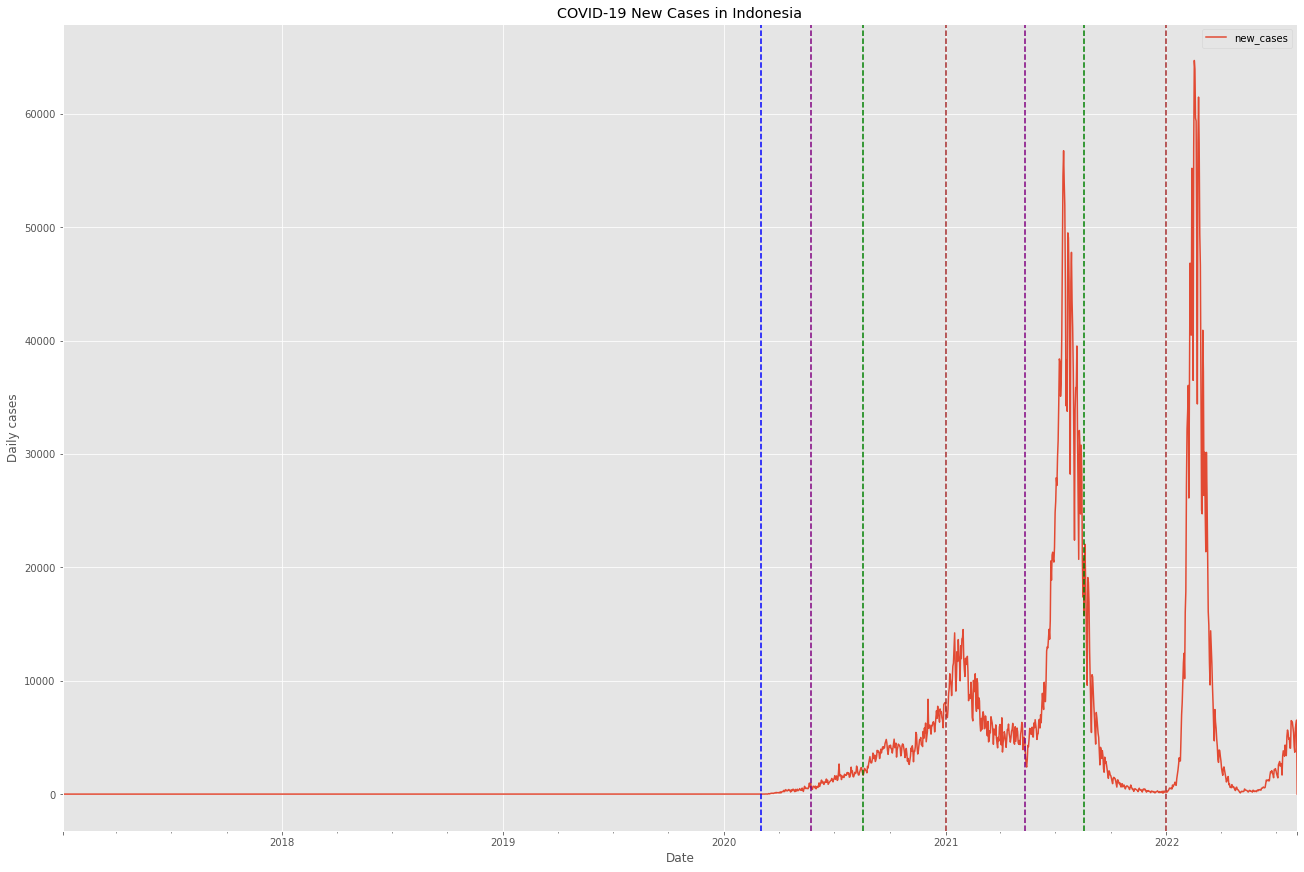

In [35]:
# COVID-19 daily cases plot
fig, ax = plt.subplots(constrained_layout = True)
covid_data_expanded.set_index('date_reported').plot(ax = ax, 
                                                    figsize = (18,12))

# First date COVID discovery in Indonesia
ax.axvline(x = "2020-03-02", 
           color = 'blue', 
           linestyle = '--')

# 2020 Eid Al-Fitr
ax.axvline(x = "2020-05-23", 
           color = 'purple', 
           linestyle = '--') 

# Indonesia's Independence Day
ax.axvline(x = "2020-08-17", 
           color = 'green', 
           linestyle = '--') 

# 2021 New Year
ax.axvline(x = "2021-01-01", 
           color = 'brown', 
           linestyle = '--')

# 2021 Eid Al-Fitr
ax.axvline(x = "2021-05-12", 
           color = 'purple', 
           linestyle = '--') 

# Indonesia's Independence Day
ax.axvline(x = "2021-08-17", 
           color = 'green', 
           linestyle = '--') 

# 2022 New Year
ax.axvline(x = "2022-01-01", 
           color = 'brown', 
           linestyle = '--') 

ax.set_ylabel("Daily cases")
ax.set_xlabel("Date")
ax.set_title('COVID-19 New Cases in Indonesia')

Text(0.5, 1.0, 'COVID-19 New Cases in Indonesia')

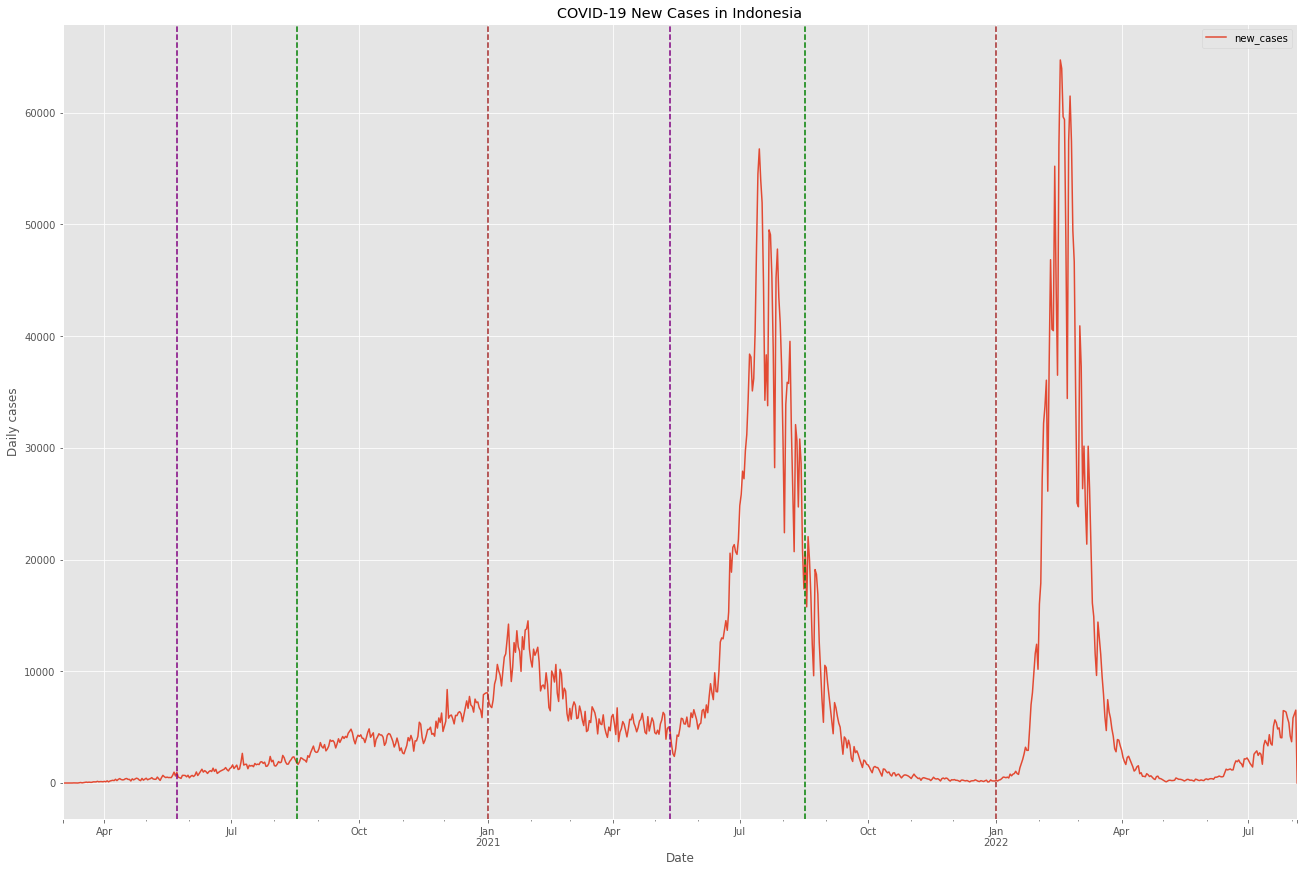

In [36]:
# COVID-19 daily cases plot
fig, ax = plt.subplots(constrained_layout = True)
covid_data_expanded.set_index('date_reported')["2020-03-02":].plot(ax = ax, 
                                                                   figsize = (18,12))

# First date COVID discovery in Indonesia
ax.axvline(x = "2020-03-02", 
           color = 'blue', 
           linestyle = '--')

# 2020 Eid Al-Fitr
ax.axvline(x = "2020-05-23", 
           color = 'purple', 
           linestyle = '--') 

# Indonesia's Independence Day
ax.axvline(x = "2020-08-17", 
           color = 'green', 
           linestyle = '--') 

# 2021 New Year
ax.axvline(x = "2021-01-01", 
           color = 'brown', 
           linestyle = '--')

# 2021 Eid Al-Fitr
ax.axvline(x = "2021-05-12", 
           color = 'purple', 
           linestyle = '--') 

# Indonesia's Independence Day
ax.axvline(x = "2021-08-17", 
           color = 'green', 
           linestyle = '--') 

# 2022 New Year
ax.axvline(x = "2022-01-01", 
           color = 'brown', 
           linestyle = '--') 

ax.set_ylabel("Daily cases")
ax.set_xlabel("Date")
ax.set_title('COVID-19 New Cases in Indonesia')

From the graphs above, we can see that:
1. There is a significant **increment** on daily cases, especially **2-4 weeks after New Year's Holiday**, because people's mobility during holiday is very high, and will most likely spread the virus.
2. Significant **increment** trend is also found not long **after Eid Fitri Holiday**, since the majority of Indonesian are Muslim, and usually people go back to their hometown on such occassion, making certain locations are crowded, and the virus will most likely to spread.

## Currency Exchange

In this analysis, we will use the 'Close' feature, as

1. 'Close' price reflects all of the information available to all market participants (especially institutional market participants who have more accurate information) at the end of trading the stock.
2. (especially for hedge funds or mutual fund managers) the close price is a determinant of the performance and wealth of investors for the day.
3. 'Close' price reflects the price position at which the investor dares to hold a position, in the face of all information that may occur at night, when there is no trade.
4. More than 90% of technical indicators used by technical analysts use close prices as their main input. This causes the position of the price to close, can trigger a buy signal or a sell signal.

Source : https://sahamology.id/arti-harga-open-harga-high-harga-low-dan-harga-close-dalam-analisis-teknikal/

In [37]:
# IDR/USD
idr_usd = idr_usd[['date', 'close']]

# IDR/JPY
idr_jpy = idr_jpy[['date', 'close']]

Text(0.5, 1.0, 'IDR/JPY Currency Exchange 2017 - 2022')

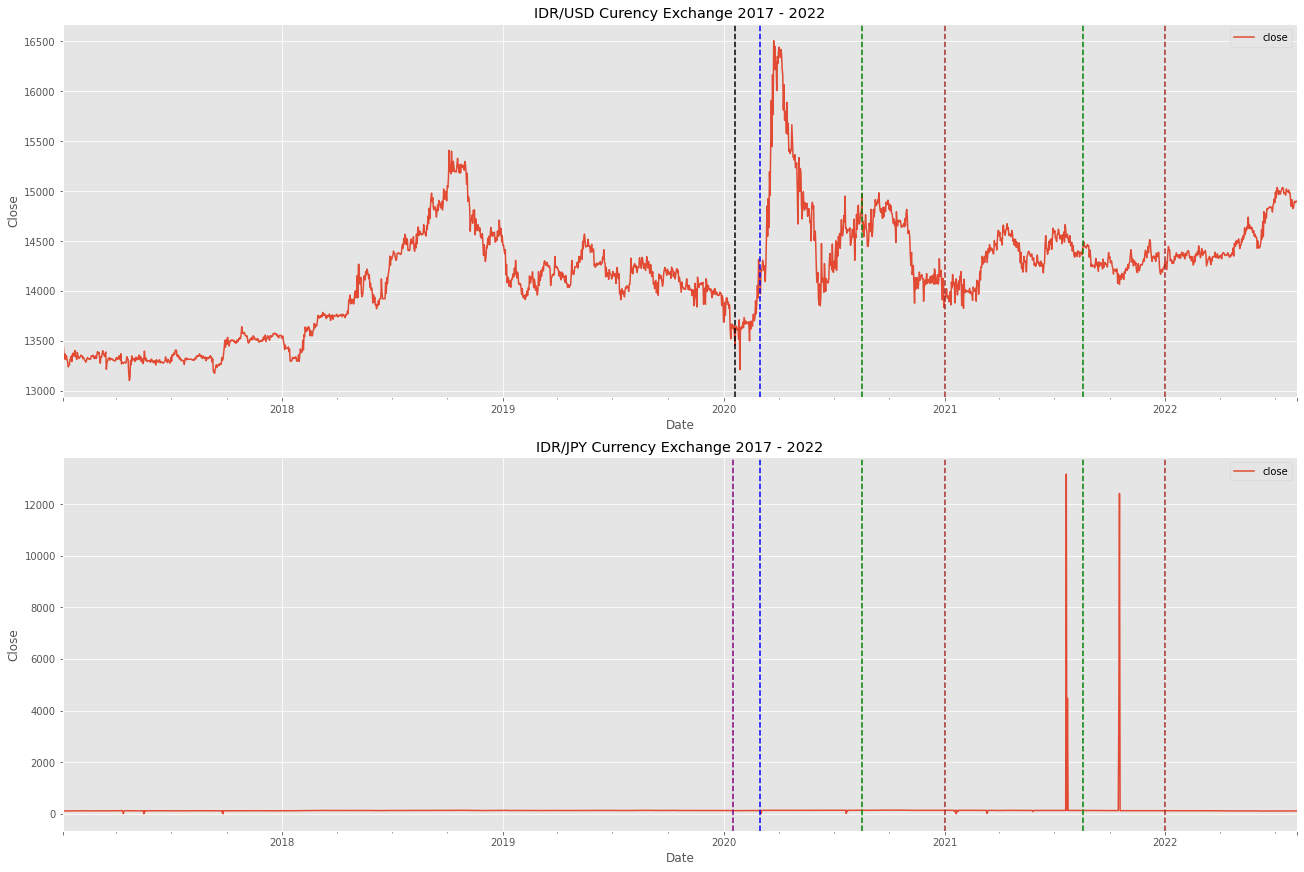

In [38]:
# Indonesia's Currency Exchange plot
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout = True)
idr_usd.set_index('date').plot(ax = ax1, 
                               figsize = (18,12))

idr_jpy.set_index('date').plot(ax = ax2, 
                               figsize = (18,12))

# First date COVID discovery
ax1.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') # in Indonesia

ax2.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') # in Indonesia

ax1.axvline(x = "2020-01-20", 
            color = 'black', 
            linestyle = '--') # in USA

ax2.axvline(x = "2020-01-16", 
            color = 'purple', 
            linestyle = '--') # in Japan

# Indonesia's Independence Day
ax1.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--')

# 2021 New Year
ax1.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2021-08-17", 
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2021-08-17", 
            color = 'green', 
            linestyle = '--')

# 2022 New Year
ax1.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--')

ax1.set_ylabel("Close")
ax2.set_ylabel("Close")

ax1.set_xlabel("Date")
ax2.set_xlabel("Date")

ax1.set_title('IDR/USD Curency Exchange 2017 - 2022')
ax2.set_title('IDR/JPY Currency Exchange 2017 - 2022')

It seems that there are outliers in the data, but we will **let them** as it is in this analysis. Since it is probably happen because of an **error in the system**.

### Post COVID-19 Discovery

Text(0.5, 1.0, 'IDR/JPY Currency Exchange 2017 - 2022')

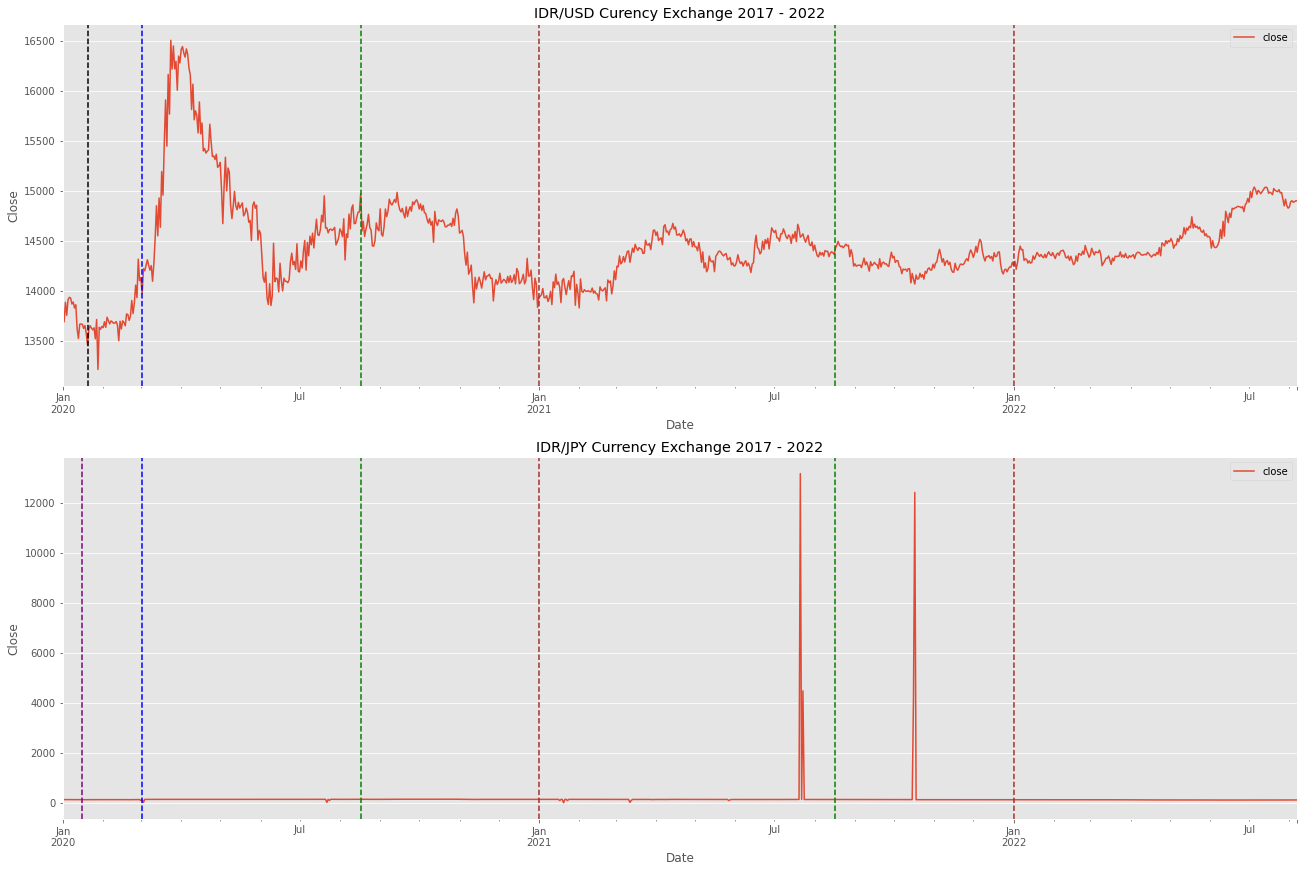

In [39]:
# Indonesia's Currency Exchange plot
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout = True)
idr_usd.set_index('date')["2020-01-01":].plot(ax = ax1, 
                                              figsize = (18,12))

idr_jpy.set_index('date')["2020-01-01":].plot(ax = ax2, 
                                              figsize = (18,12))

# First date COVID discovery
ax1.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') # in Indonesia

ax2.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') # in Indonesia

ax1.axvline(x = "2020-01-20", 
            color = 'black', 
            linestyle = '--') # in USA

ax2.axvline(x = "2020-01-16", 
            color = 'purple', 
            linestyle = '--') # in Japan

# Indonesia's Independence Day
ax1.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--')

# 2021 New Year
ax1.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2021-08-17", 
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2021-08-17", 
            color = 'green', 
            linestyle = '--')

# 2022 New Year
ax1.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--')

ax1.set_ylabel("Close")
ax2.set_ylabel("Close")

ax1.set_xlabel("Date")
ax2.set_xlabel("Date")

ax1.set_title('IDR/USD Curency Exchange 2017 - 2022')
ax2.set_title('IDR/JPY Currency Exchange 2017 - 2022')

# Stock Market Price

By the same argument as the 'Currency Exchange' section, we will also use the 'Close' feature in this analysis.

In [40]:
# BBCA.JK
bbca_info = bbca_info[['date', 'close']]

# CMPP.JK
jkse_info = jkse_info[['date', 'close']]

Text(0.5, 1.0, '^JKSE Stock Price 2017 - 2022')

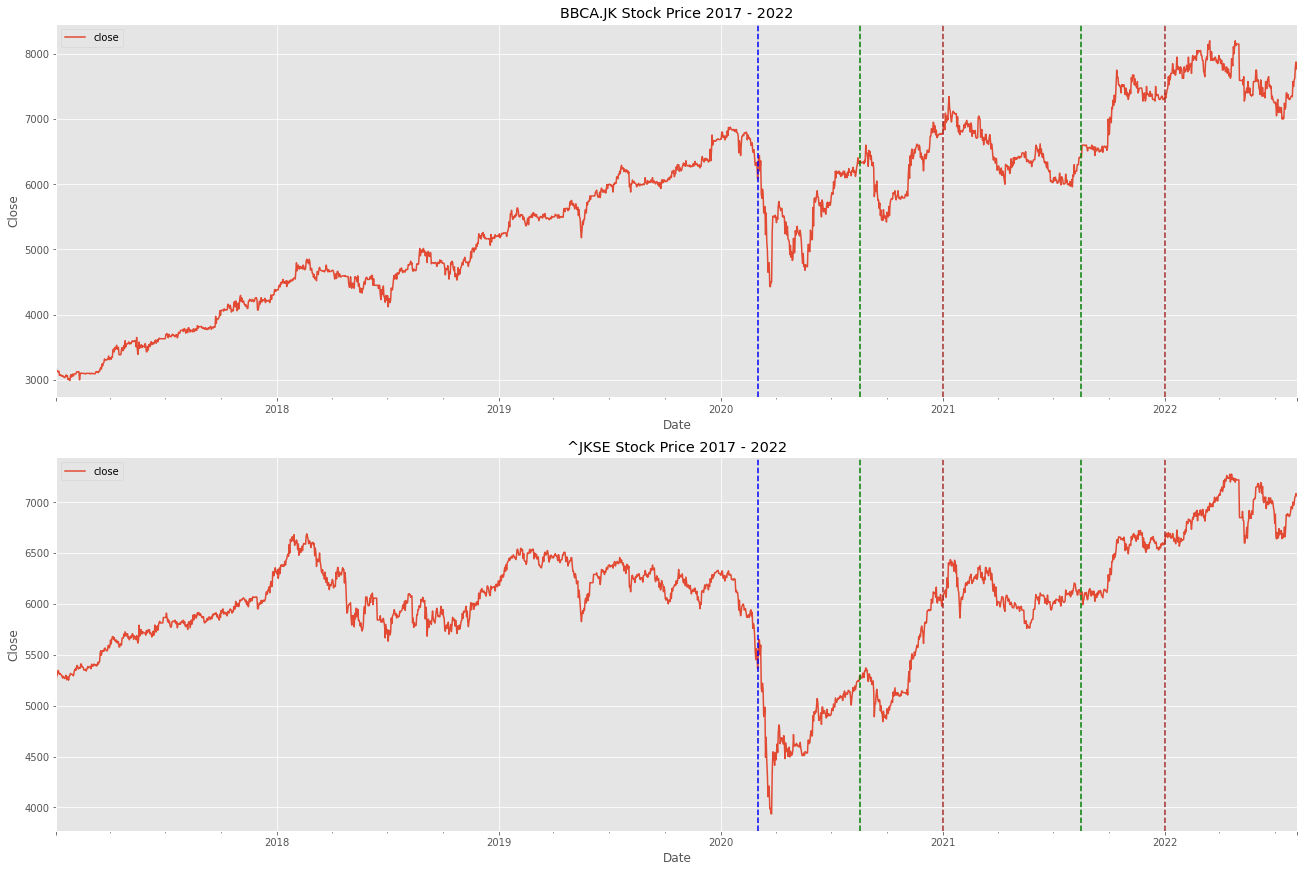

In [41]:
# Stock market price plot
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout = True)
bbca_info.set_index('date').plot(ax = ax1, 
                                 figsize = (18,12))

jkse_info.set_index('date').plot(ax = ax2, 
                                 figsize = (18,12))

# First date COVID discovery in Indonesia
ax1.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') 

ax2.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2020-08-17", 
            color = 'green',
            linestyle = '--') 

ax2.axvline(x = "2020-08-17",
            color = 'green', 
            linestyle = '--')

# 2021 New Year
ax1.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2021-08-17",
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2021-08-17", 
            color = 'green',
            linestyle = '--')

# 2022 New Year
ax1.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2022-01-01", 
            color = 'brown', 
            linestyle = '--')

ax1.set_ylabel("Close")
ax2.set_ylabel("Close")

ax1.set_xlabel("Date")
ax2.set_xlabel("Date")

ax1.set_title('BBCA.JK Stock Price 2017 - 2022')
ax2.set_title('^JKSE Stock Price 2017 - 2022')

### Post COVID-19 Discovery

Text(0.5, 1.0, '^JKSE Stock Price post COVID-19 Discovery in Indonesia')

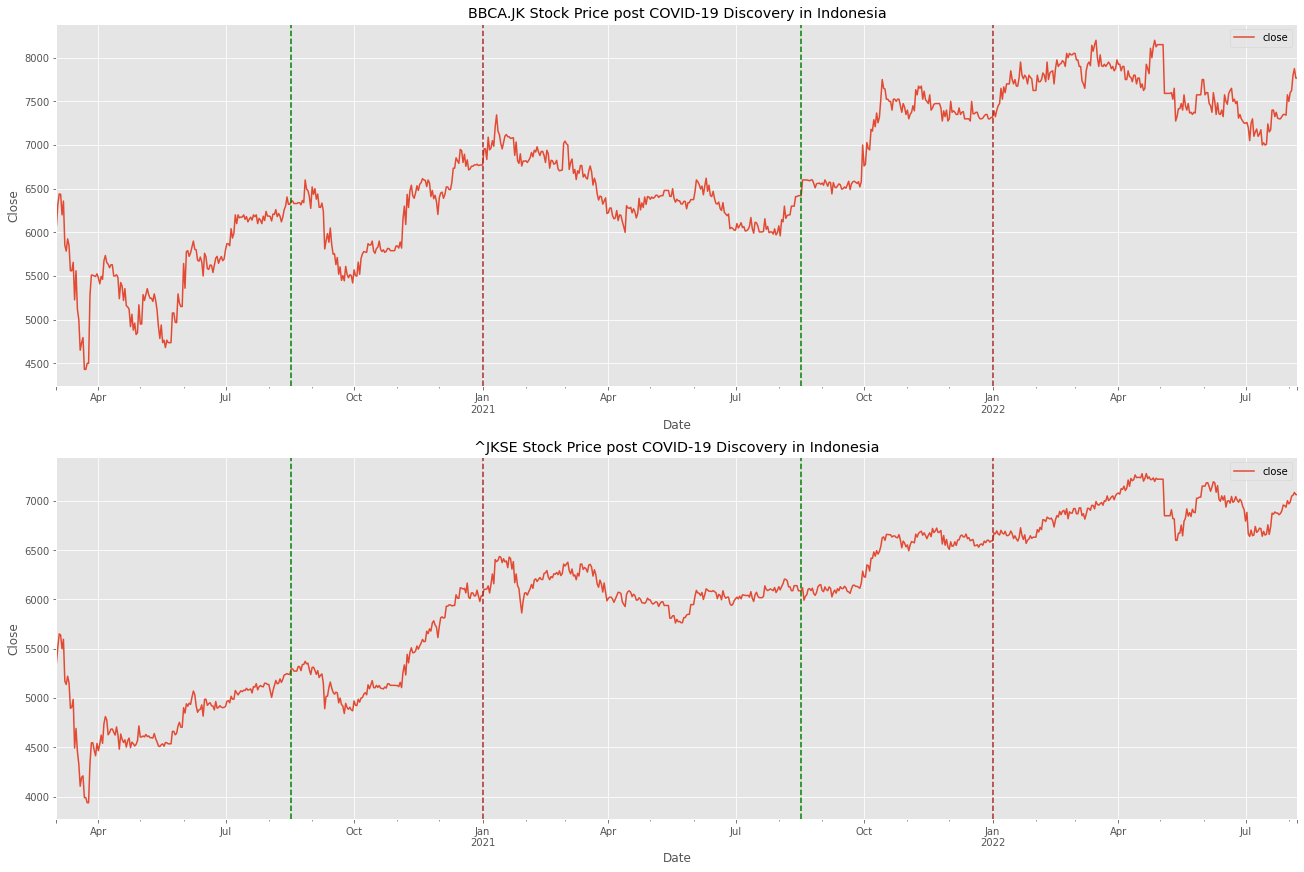

In [42]:
# Stock market price post COVID plot
fig, (ax1, ax2) = plt.subplots(2,1, constrained_layout = True)
bbca_info.set_index('date')["2020-03-02":].plot(ax = ax1, 
                                                figsize = (18,12))

jkse_info.set_index('date')["2020-03-02":].plot(ax = ax2, 
                                                figsize = (18,12))

# First date COVID discovery in Indonesia
ax1.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--') 

ax2.axvline(x = "2020-03-02", 
            color = 'blue', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2020-08-17", 
            color = 'green', 
            linestyle = '--')

# 2021 New Year
ax1.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2021-01-01", 
            color = 'brown', 
            linestyle = '--')

# Indonesia's Independence Day
ax1.axvline(x = "2021-08-17",
            color = 'green', 
            linestyle = '--') 

ax2.axvline(x = "2021-08-17", 
            color = 'green',
            linestyle = '--')

# 2022 New Year
ax1.axvline(x = "2022-01-01",
            color = 'brown', 
            linestyle = '--') 

ax2.axvline(x = "2022-01-01",
            color = 'brown', 
            linestyle = '--')

ax1.set_ylabel("Close")
ax2.set_ylabel("Close")

ax1.set_xlabel("Date")
ax2.set_xlabel("Date")

ax1.set_title('BBCA.JK Stock Price post COVID-19 Discovery in Indonesia')
ax2.set_title('^JKSE Stock Price post COVID-19 Discovery in Indonesia')

From the graphs above, we can see that:
1. On the **first 3-4 weeks of COVID-19 discovery in Indonesia**, the price of BBCA.JK and ^JKSE stock market went **down** for **31.21%** and **30.31%**, respecively, and managed to recover since the first two weeks of April 2020.
2. **2-3 weeks after Indonesia's Independence day in 2020**, there was also a **decremental** trend for both stock market price, and it went down for **8.65%** and **7.62%** , respectively. But these stock prices recovered since October 2020.
3. Not long after **2021' New Year's Eve**, there is also a **decremental** trend for both stock market price, and it went down for **15.37%** and **3.42%**, respectively, and did not show any sign of recovery until October 2021.
4. Surprisingly, both stock market prices give an **incremental** trend starting from **October in 2020 and 2021**.

# Hypothesis Testing

We will see if any pair of these datasets correlate with each other by using hypothesis testing with 0.05 significance level.

## Economic Datasets

Notice that there are datasets which start from 2017-01-02, and there is also datasets which start from 2017-01-03. For consistency, we will drop the data on 2017-01-02 and start the index from 2017-01-03.

In [43]:
idr_usd = idr_usd.set_index('date')['2017-01-03':]

idr_jpy = idr_jpy.set_index('date')['2017-01-03':]

bbca_info = bbca_info.set_index('date')['2017-01-03':]

jkse_info = jkse_info.set_index('date')['2017-01-03':]

In [44]:
df = pd.DataFrame()
df.index = idr_usd.index
df['idr_usd'] = idr_usd.values
df['idr_jpy'] = idr_jpy.values
df['bbca_info'] = bbca_info.values
df['jkse_info'] = jkse_info.values

significance_level = 0.05
print('Significance level = 0.05 \n')

temp = pd.DataFrame()
features = []
correlations = []
p_values = []
conclusions = []
for col in df.columns:
    for sub_col in df.columns:
        if col != sub_col:
            r, p = pearsonr(df.dropna()[col], df.dropna()[sub_col])
            
            features.append(f'{col} vs. {sub_col}')
            correlations.append(r)
            p_values.append(p)
            
            if p < significance_level:
                conclusions.append('Reject H0')
                
            else:
                conclusions.append('Do not reject H0')

        else:
            pass
        
temp['features'] = features
temp['correlations'] = correlations
temp['p_values'] = p_values
temp['conclusions'] = conclusions

temp

Significance level = 0.05 



,features,correlations,p_values,conclusions
0,idr_usd vs. idr_jpy,0.019858,3.696661e-01,Do not reject H0
1,idr_usd vs. bbca_info,0.479181,8.936120e-118,Reject H0
2,idr_usd vs. jkse_info,-0.140791,1.640788e-10,Reject H0
3,idr_jpy vs. idr_usd,0.019858,3.696661e-01,Do not reject H0
4,idr_jpy vs. bbca_info,0.037440,9.068106e-02,Do not reject H0
5,idr_jpy vs. jkse_info,0.014844,5.024874e-01,Do not reject H0
6,bbca_info vs. idr_usd,0.479181,8.936120e-118,Reject H0
7,bbca_info vs. idr_jpy,0.037440,9.068106e-02,Do not reject H0
8,bbca_info vs. jkse_info,0.492985,1.415347e-125,Reject H0
9,jkse_info vs. idr_usd,-0.140791,1.640788e-10,Reject H0


Based on the hypothesis testing result, we can conclude that **IDR/USD** **moderately correlates** with both BBCA dataset, with pearson coefficient of 0.470050. In addition, BBCA dataset also **moderately correlates** with both ^JKSE dataset, with pearson coefficient of 0.482089, while the other pair datasets do not correlate with each other, using significance level of 0.05.

**Note**: IDR/USD and ^JKSE datasets do correlate with each other as its p-value is significant, but put in mind that its pearson coefficient is **close to 0**. And such, we will **treat** it as they **do not correlate** with each other.

## vs. COVID Data

In [45]:
covid_data = covid_data.set_index('date_reported')

In [46]:
idr_usd = idr_usd.reset_index()
idr_usd_covid = idr_usd.set_index('date')['2020-01-03':covid_data.index[-1].strftime('%Y-%m-%d')]
idr_usd_covid = idr_usd_covid.reset_index()
idr_usd = idr_usd.set_index('date')

idr_jpy = idr_jpy.reset_index()
idr_jpy_covid = idr_jpy.set_index('date')['2020-01-03':covid_data.index[-1].strftime('%Y-%m-%d')]
idr_jpy_covid = idr_jpy_covid.reset_index()
idr_jpy = idr_jpy.set_index('date')

bbca_info = bbca_info.reset_index()
bbca_info_covid = bbca_info.set_index('date')['2020-01-03':covid_data.index[-1].strftime('%Y-%m-%d')]
bbca_info_covid = bbca_info_covid.reset_index()
bbca_info = bbca_info.set_index('date')

jkse_info = jkse_info.reset_index()
jkse_info_covid = jkse_info.set_index('date')['2020-01-03':covid_data.index[-1].strftime('%Y-%m-%d')]
jkse_info_covid = jkse_info_covid.reset_index()
jkse_info = jkse_info.set_index('date')

In [47]:
df = pd.DataFrame()
df.index = covid_data.index
df['covid'] = covid_data['new_cases'].values
df['idr_usd'] = idr_usd_covid['close'].values
df['idr_jpy'] = idr_jpy_covid['close'].values
df['bbca_info'] = bbca_info_covid['close'].values
df['jkse_info'] = jkse_info_covid['close'].values

significance_level = 0.05
print('Significance level = 0.05 \n')

temp = pd.DataFrame()
features = []
correlations = []
p_values = []
conclusions = []
for col in df.columns:
    for sub_col in df.columns:
        if col != sub_col:
            r, p = pearsonr(df.dropna()[col], df.dropna()[sub_col])
            
            features.append(f'{col} vs. {sub_col}')
            correlations.append(r)
            p_values.append(p)
            
            if p < significance_level:
                conclusions.append('Reject H0')
                
            else:
                conclusions.append('Do not reject H0')

        else:
            pass
        
temp['features'] = features
temp['correlations'] = correlations
temp['p_values'] = p_values
temp['conclusions'] = conclusions

temp

Significance level = 0.05 



,features,correlations,p_values,conclusions
0,covid vs. idr_usd,-0.070193,3.086987e-02,Reject H0
1,covid vs. idr_jpy,0.070321,3.056527e-02,Reject H0
2,covid vs. bbca_info,0.114538,4.158528e-04,Reject H0
3,covid vs. jkse_info,0.198934,6.728587e-10,Reject H0
4,idr_usd vs. covid,-0.070193,3.086987e-02,Reject H0
5,idr_usd vs. idr_jpy,-0.015855,6.262250e-01,Do not reject H0
6,idr_usd vs. bbca_info,-0.397763,3.214844e-37,Reject H0
7,idr_usd vs. jkse_info,-0.398127,2.729728e-37,Reject H0
8,idr_jpy vs. covid,0.070321,3.056527e-02,Reject H0
9,idr_jpy vs. idr_usd,-0.015855,6.262250e-01,Do not reject H0


In [48]:
df

,covid,idr_usd,idr_jpy,bbca_info,jkse_info
date_reported,,,,,
2020-01-03,0,13884.786133,127.906448,6800.000000,6323.465820
2020-01-04,0,13754.796549,126.566427,6800.000000,6323.465820
2020-01-05,0,13909.350911,128.488373,6718.333333,6254.145020
2020-01-06,0,13934.316406,129.048325,6735.000000,6257.402832
2020-01-07,0,13926.500000,128.111115,6740.000000,6279.346191
...,...,...,...,...,...
2022-08-01,3696,14838.000000,112.768326,7500.000000,6968.783203
2022-08-02,5827,14890.099609,111.858162,7600.000000,6988.157227
2022-08-03,6167,14900.000000,111.200256,7625.000000,7046.634766


# Model Identification

In this project, for simplicity purposes, we will only focus on performing TSA on the BBCA data. If you want to perform TSA on another data, then just repeat the process and apply it to the data you want to perform TSA.

In particular, these dataset is chosen since it is a financial data, so it has high volatility, and one of our aim here is to compare base model with ARCH/GARCH model. In addition, from the previous section, we know that BBCA dataset moderately/strongly correlate with other datasets, and we will use ARIMAX model with the other dataset as the exogenous arguments to predict the BBCA dataset.

## Check Stationary

To perform TSA, the data itself **has to be a stationary data** as its statistical properties do not change over time. The assumption in time series data modeling is that each observation is independent of each other.

<Figure size 1296x864 with 0 Axes>

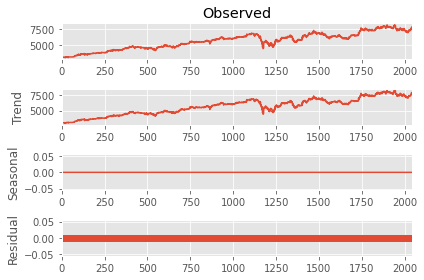

In [49]:
plt.figure(figsize = (18,12))

additive_result = seasonal_decompose(bbca_info.values, model = 'additive', period = 1)
additive_result.plot()
plt.show()

<Figure size 1296x864 with 0 Axes>

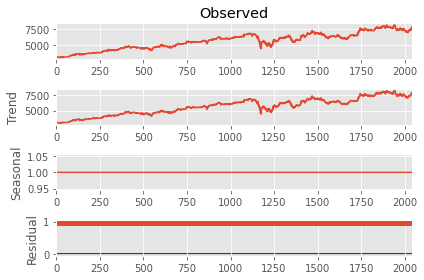

In [50]:
plt.figure(figsize = (18,12))

multiplicative_result = seasonal_decompose(bbca_info.values, model = 'multiplicative', period = 1)
multiplicative_result.plot()
plt.show()

In particular, we had observe from the the graph above that our dataset has **increment trend** (additive, in particular, as the multiplicative residual are high. But we will see this in further section). Thus, it **should be not stationer**. We will check this claim by **ADF-Test using significance level 95%** ($\alpha$ = 0.05) and from its **ACF/PACF Plot**.

In [51]:
# Test
test = adfuller(bbca_info['close'])

# Statistic result
print('Augmented-Dickey Fuller Result :', test[0])

# p-value
print('p-value :', test[1])

Augmented-Dickey Fuller Result : -1.380625789055763
p-value : 0.591528312671061


C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


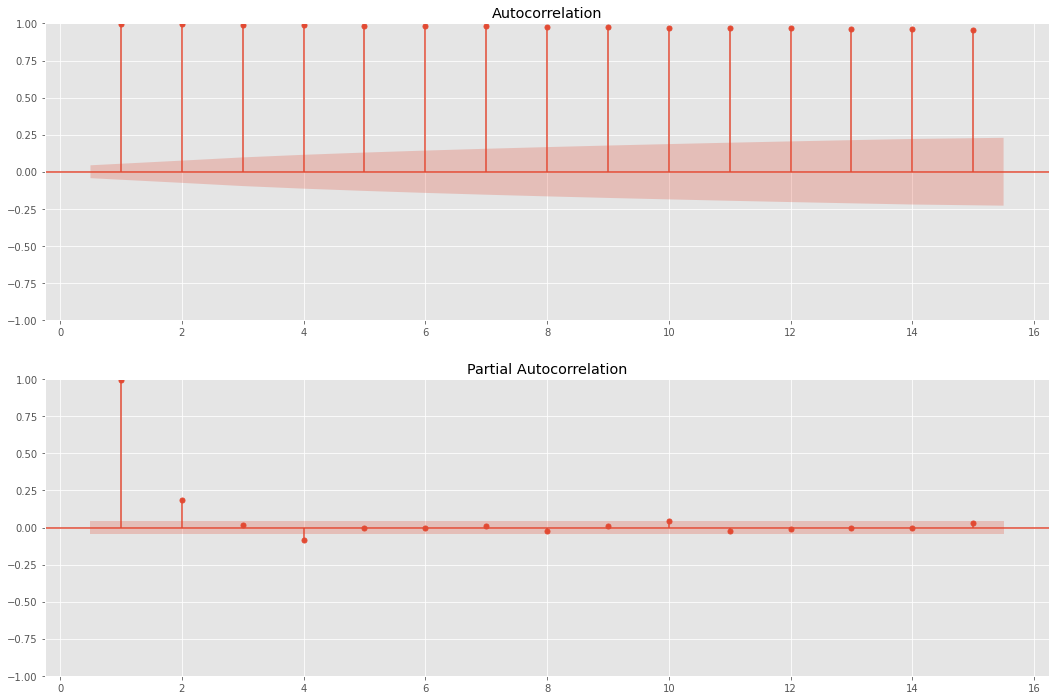

In [52]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, 
                               figsize = (18,12))
 
# ACF Plot from stock market price data
plot_acf(bbca_info, 
         lags = 15, 
         zero = False,
         ax = ax1)

# PACF Plot from stock market price data
plot_pacf(bbca_info, 
          lags = 15, 
          zero = False, 
          ax = ax2)

plt.show()

Based on the hypothesis testing result above, we can conclude that the BBCA dataset is **not stationary**, as its **p-value** is **higher** than the $\alpha$. And then, also notice that it has **no significant** change in the **ACF** plot. So, we will perform **differentiation** on this dataset.

## Convert into Stationer Data

If the data is not stationary, it is necessary to transform the data. One of the transformation methods is to use the **differentiation method**.

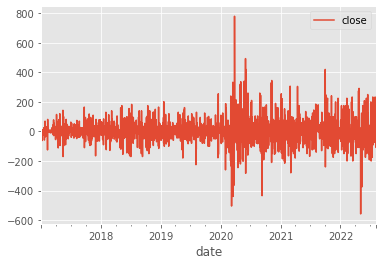

In [53]:
# Differentiation
bbca_info_diff = bbca_info.diff().dropna()

# Differentiation result plotting
bbca_info_diff.plot()
plt.show()

In [54]:
# Adfuller Test
test_1 = adfuller(bbca_info_diff['close'])

# Statistic result
print('Augmented-Dickey Fuller Result :', test_1[0])

# p-value
print('p-value :', test_1[1])

Augmented-Dickey Fuller Result : -12.30765355230958
p-value : 7.210296923501161e-23


Since the p-value is already lower than the $\alpha$, then it means that the BBCA dataset is now stationary.

# Model Estimation

To decide the order of p and q in the ARIMA model, i.e. estimating the most suitable model for the data, there are 2 steps that we can do:

1. **Manual**: Analyze the ACF and PACF plot and look at which lag the cut off happen to determine the p and q then look for the least AIC and BIC model.

2. **Auto**: Use automated iterative steps to look for the model with the least AIC for the given range of p and q using pmdarima package.

For simplicity, here we will only use the **Auto method** and will only look for the least **AIC** model. Here, AIC criteria is chosen because in financial datasets, the volatility is high, and considering the **unppredicted external factors** (e.g. COVID-19), there will **not** be a **fixed/final model** in such cases.

## Automation Method (Auto-ARIMA)

### Best Model Estimation

In [55]:
# Get best ARIMA model with lowest AIC
results_auto_arima_bbca = pm.auto_arima(bbca_info, 
                                        start_p = 0,
                                        start_q = 0,
                                        max_p = 5,
                                        max_q = 5,
                                        d = None,
                                        trace = True,
                                        error_action = 'ignore')

results_auto_arima_bbca.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23830.180, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23656.226, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23655.398, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23829.703, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23650.288, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23633.131, Time=1.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23643.121, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23611.438, Time=1.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23616.836, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=23613.117, Time=1.66 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=23613.093, Time=1.88 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23616.855, Time=0.73 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=23611.787, Time=0.32 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=23615.118, Time=2.49 sec
 ARIMA(3,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2043
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -11799.719
Date:                Sun, 07 Aug 2022   AIC                          23611.438
Time:                        22:20:44   BIC                          23645.168
Sample:                             0   HQIC                         23623.810
                               - 2043                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4750      1.025      1.439      0.150      -0.533       3.484
ar.L1          0.1121      0.084      1.329      0.184      -0.053       0.277
ar.L2          0.0805      0.026      3.109      0.002       0.030       0.131
ar.L3          0.1552      0.015     10.435      0.000       0.126       0.184
ma.L1         -0.4211      0.083     -5.053      0.000      -0.584      -0.258
sigma2      6121.8365     79.467     77.036      0.000    5966.084    6277.589
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12005.55
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.42   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the summary table above, we can see that the **ARIMA(3,1,1)** has the **lowest AIC**. Thus, we will try to analyze the performance of that model by using **diagnostic test**. If it is not suited to be a predictor model, we will pick another model (iteratively).

In [56]:
# Model ARIMA(3,1,1)
model_1_bbca = SARIMAX(bbca_info, 
                       order = (3,1,1))

results_1_bbca = model_1_bbca.fit()

results_1_bbca.summary()

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2043
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -11800.797
Date:                Sun, 07 Aug 2022   AIC                          23611.594
Time:                        22:20:45   BIC                          23639.703
Sample:                    01-03-2017   HQIC                         23621.904
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1210      0.082      1.475      0.140      -0.040       0.282
ar.L2          0.0839      0.025      3.376      0.001       0.035       0.133
ar.L3          0.1566      0.015     10.516      0.000       0.127       0.186
ma.L1         -0.4290      0.081     -5.303      0.000      -0.588      -0.270
sigma2      6124.5968     78.867     77.657      0.000    5970.020    6279.174
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             12009.88
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               3.41   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Diagnostic Test

**Heteroscedasticity**

----

$H_0$ = Error residuals are homoscedastic

$H_1$ = Error residuals are heteroscedastic

Based on the table above, get that the p-value for Heteroscedasticity statistical test is near 0.00. Since p-value $\approx$ 0.00 < 0.05 = $\alpha$, we **reject our null hypothesis**. Thus, we conclude that our **error residuals** are **heteroscedastic** or have the difference variances using significance level of 0.05.

**Jarque-Bera**

----

$H_0$ = The data is normally distributed

$H_1$ = The data is not normally distributed

Based on the table above, get that the p-value for Jarque-Bera statistical test is near 0.00. Since p-value $\approx$ 0.00 < 0.05 = $\alpha$, we **reject our null hypothesis**. Thus, we conclude that our **data is not normally distributed** using significance level of 0.05.


**Ljung-Box**

----

$H_0$ = The residuals are independently distributed

$H_1$ = The residuals are not independently distributed; they exhibit serial correlation.

Based on the table above, get that the p-value for Ljung-Box statistical test is 0.93. Since p-value = 0.93 > 0.05 = $\alpha$, we **fail to reject our null hypothesis**. Thus, we conclude that our **residuals** are **independently distributed** using significance level of 0.05. Since the residuals for our time series model are independent, the assumption people usually make when creating a model are fulfilled in our case. Thus, we can say that our ARIMA(3,1,1) model is good for forecasting and can move on to the next step.

### Conclusion

Based on the hypothesis testing and the model summary above, we can conclude that our ARIMA(3,1,1) model has the following characteristics:

1. The error residuals are **heteroscedastic**,
2. The data distribution does **not** follow **normal distribution**,
3. **Good for forecasting**, as the residuals are independently distributed

based on 0.05 significance level.

## ARIMAX Model

Next, since we know that BBCA datasets moderately/strongly correlate with other datasets, we will try to use the other as the exogenous arguments to predict our BBCA dataset. In this case, we will use **only IDR/USD** dataset as our **exogenous argument**. JKSE dataset is not included since both are stock market dataset, and it is not a wise choice to use dataset with the same 'type' as the exogenous argument. In the other hand, COVID dataset is not used since it has different starting point, and if we want to use it as our exogenous argument, we have to cut our BBCA dataset, which will cause a huge loss information, not considering that COVID is only temporary.

In [57]:
# Fetch other datasets and 'merge' it into BBCA dataset
exog_idr_usd = pd.DataFrame()
exog_idr_usd.index = bbca_info.index
exog_idr_usd['close'] = idr_usd['2017-01-03':]['close']

exog_idr_usd

,close
date,
2017-01-03,13506.000000
2017-01-04,13443.000000
2017-01-05,13348.000000
2017-01-06,13319.000000
2017-01-07,13370.000000
...,...
2022-08-03,14900.000000
2022-08-04,14884.700195
2022-08-05,14891.599935


### Best Model Estimation

In [58]:
# Get best ARIMAX model with lowest AIC
results_auto_arimax_bbca = pm.auto_arima(bbca_info, 
                                         start_p = 0,
                                         start_q = 0,
                                         max_p = 5,
                                         max_q = 5,
                                         d = None,
                                         exog = exog_idr_usd.values,
                                         trace = True,
                                         error_action = 'ignore')

results_auto_arimax_bbca.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23830.180, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23656.226, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23655.398, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23829.703, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23650.288, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23633.131, Time=1.25 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23643.121, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23611.438, Time=1.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23616.836, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=23613.117, Time=4.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=23613.093, Time=1.88 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23616.855, Time=0.70 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=23611.787, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=23615.118, Time=2.89 sec
 ARIMA(3,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2043
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -11799.719
Date:                Sun, 07 Aug 2022   AIC                          23611.438
Time:                        22:20:59   BIC                          23645.168
Sample:                             0   HQIC                         23623.810
                               - 2043                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4750      1.025      1.439      0.150      -0.533       3.484
ar.L1          0.1121      0.084      1.329      0.184      -0.053       0.277
ar.L2          0.0805      0.026      3.109      0.002       0.030       0.131
ar.L3          0.1552      0.015     10.435      0.000       0.126       0.184
ma.L1         -0.4211      0.083     -5.053      0.000      -0.584      -0.258
sigma2      6121.8365     79.467     77.036      0.000    5966.084    6277.589
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12005.55
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.42   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the summary table above, we can see that the **ARIMAX(3,1,1,'IDR/USD')** has the **lowest AIC**. Thus, we will try to analyze the performance of that model by using **diagnostic test**. If it is not suited to be a predictor model, we will pick another model (iteratively).

In [59]:
# Model ARIMAX(3,1,1,'IDR/USD')
model_2_bbca = SARIMAX(bbca_info, 
                       order = (3,1,1),
                       exog = exog_idr_usd.values)

results_2_bbca = model_2_bbca.fit()

results_2_bbca.summary()

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2043
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -11794.458
Date:                Sun, 07 Aug 2022   AIC                          23600.915
Time:                        22:21:01   BIC                          23634.645
Sample:                    01-03-2017   HQIC                         23613.287
                         - 08-07-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0767      0.014     -5.318      0.000      -0.105      -0.048
ar.L1          0.1247      0.093      1.346      0.178      -0.057       0.306
ar.L2          0.0840      0.031      2.718      0.007       0.023       0.145
ar.L3          0.1521      0.016      9.737      0.000       0.121       0.183
ma.L1         -0.4409      0.091     -4.871      0.000      -0.618      -0.263
sigma2      6086.9847     78.099     77.940      0.000    5933.914    6240.055
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             12455.49
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               3.41   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Diagnostic Test

**Heteroscedasticity**

----

$H_0$ = Error residuals are homoscedastic

$H_1$ = Error residuals are heteroscedastic

Based on the table above, get that the p-value for Heteroscedasticity statistical test is near 0.00. Since p-value $\approx$ 0.00 < 0.05 = $\alpha$, we **reject our null hypothesis**. Thus, we conclude that our **error residuals** are **heteroscedastic** or have the difference variances using significance level of 0.05.

**Jarque-Bera**

----

$H_0$ = The data is normally distributed

$H_1$ = The data is not normally distributed

Based on the table above, get that the p-value for Jarque-Bera statistical test is near 0.00. Since p-value $\approx$ 0.00 < 0.05 = $\alpha$, we **reject our null hypothesis**. Thus, we conclude that our **data is not normally distributed** using significance level of 0.05.


**Ljung-Box**

----

$H_0$ = The residuals are independently distributed

$H_1$ = The residuals are not independently distributed; they exhibit serial correlation.

Based on the table above, get that the p-value for Ljung-Box statistical test is 0.93. Since p-value = 0.93 > 0.05 = $\alpha$, we **fail to reject our null hypothesis**. Thus, we conclude that our **residuals** are **independently distributed** using significance level of 0.05. Since the residuals for our time series model are independent, the assumption people usually make when creating a model are fulfilled in our case. Thus, we can say that our ARIMAX(3,1,1,'IDR/USD') model is good for forecasting and can move on to the next step.

### Conclusion

Based on the hypothesis testing and the model summary above, we can conclude that our ARIMAX(3,1,1,'IDR/USD') model has the following characteristics:

1. The error residuals are **heteroscedastic**,
2. The data distribution does **not** follow **normal distribution**,
3. **Good for forecasting**, as the residuals are independently distributed

based on 0.05 significance level.

## SARIMA Model

From the analysis in the previous section, we know that **BBCA** stock price dataset have an **addition trend** and a **large entries/records**. As such, we will use **SARIMA** model to **train** our data instead of Holt or SES model. For simplicity, we will use a grid search to iteratively explore different combinations of parameters.

### Best Model Estimation

In [60]:
def sarima_grid_search(data, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = 1e6
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = SARIMAX(data,
                              order = param,
                              seasonal_order = param_seasonal,
                              enforce_stationarity = False,
                              enforce_invertibility = False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

            except:
                continue
                
    print(f'The set of parameters with the minimum AIC is: SARIMA{param_mini}x{param_seasonal_mini} - AIC:{mini}')

Since we are observing by month, then pick **m = 12**.

In [61]:
sarima_grid_search(bbca_info, 12)

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-p

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-p

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-p

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-p

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:23413.507783279874


Based on the summary table above, we can see that the **SARIMA(1,1,1)x(0,1,1,12)** has the **lowest AIC**. Thus, we will try to analyze the performance of that model by using **diagnostic test**. If it is not suited to be a predictor model, we will pick another model (iteratively).

In [62]:
# Model SARIMA(3,1,1)
model_3_bbca = SARIMAX(bbca_info, 
                       order = (1,1,1),
                       seasonal_order = (0,1,1,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)

results_3_bbca = model_3_bbca.fit()

results_3_bbca.summary()

C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              close   No. Observations:                 2043
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood              -11702.754
Date:                            Sun, 07 Aug 2022   AIC                          23413.508
Time:                                    22:23:24   BIC                          23435.943
Sample:                                01-03-2017   HQIC                         23421.742
                                     - 08-07-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1517      0.051     -2.998      0.003      -0.251      -0.053
ma.L1         -0.1507      0.052     -2.905      0.004      -0.252      -0.049
ma.S.L12      -0.9825      0.006   -160.197      0.000      -0.995      -0.971
sigma2      6350.1577     82.201     77.252      0.000    6189.047    6511.269
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             10334.75
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.28   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Diagnostic Test

**Heteroscedasticity**

----

$H_0$ = Error residuals are homoscedastic

$H_1$ = Error residuals are heteroscedastic

Based on the table above, get that the p-value for Heteroscedasticity statistical test is near 0.00. Since p-value $\approx$ 0.00 < 0.05 = $\alpha$, we **reject our null hypothesis**. Thus, we conclude that our **error residuals** are **heteroscedastic** or have the difference variances using significance level of 0.05.

**Jarque-Bera**

----

$H_0$ = The data is normally distributed

$H_1$ = The data is not normally distributed

Based on the table above, get that the p-value for Jarque-Bera statistical test is near 0.00. Since p-value $\approx$ 0.00 < 0.05 = $\alpha$, we **reject our null hypothesis**. Thus, we conclude that our **data is not normally distributed** using significance level of 0.05.


**Ljung-Box**

----

$H_0$ = The residuals are independently distributed

$H_1$ = The residuals are not independently distributed; they exhibit serial correlation.

Based on the table above, get that the p-value for Ljung-Box statistical test is 0.88. Since p-value = 0.88 > 0.05 = $\alpha$, we **fail to reject our null hypothesis**. Thus, we conclude that our **residuals** are **independently distributed** using significance level of 0.05. Since the residuals for our time series model are independent, the assumption people usually make when creating a model are fulfilled in our case. Thus, we can say that our SARIMA(1,1,1)x(0,1,1,12) model is good for forecasting and can move on to the next step.

### Conclusions

Based on the hypothesis testing and the model summary above, we can conclude that our SARIMA(1,1,0) model has the following characteristics:

1. The error residuals are **heteroscedastic**,
2. The data distribution does **not** follow **normal distribution**,
3. **Good for forecasting**, as the residuals are independently distributed

based on 0.05 significance level.

## GARCH Model

Since we are dealing with a **financial data** which has **high volatility**, then it is a good idea to analyze and predict the future values using **GARCH model**. Here, GARCH is chosen instead of ARCH because in general, it has much **less parameters** and **performs better** than the ARCH model. The generalized autoregressive conditional heteroskedasticity (GARCH) model has only **three parameters** that allow for an **infinite number of squared roots** to influence the conditional variance.

### Best Model Estimation

In [63]:
df = bbca_info.copy()
df['close'] = 100*bbca_info['close'].pct_change()

df = df.dropna()

df.tail()

,close
date,
2022-08-03,0.328947
2022-08-04,2.295082
2022-08-05,0.961538
2022-08-06,-1.375661
2022-08-07,0.000000


In [64]:
# Model GARCH(1,1)
model_4_bbca = arch_model(df, vol = 'GARCH', p = 1, o = 0, q = 1)

results_4_bbca = model_4_bbca.fit()

results_4_bbca.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12122.395008969585
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4601.560381261772
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1106471028.3170683
Iteration:      4,   Func. Count:     27,   Neg. LLF: 3534.821597902987
Iteration:      5,   Func. Count:     33,   Neg. LLF: 3445.9768316816107
Iteration:      6,   Func. Count:     39,   Neg. LLF: 4052.306187578163
Iteration:      7,   Func. Count:     46,   Neg. LLF: 3473.6387734935315
Iteration:      8,   Func. Count:     52,   Neg. LLF: 3390.959654082278
Iteration:      9,   Func. Count:     57,   Neg. LLF: 3390.94148401863
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3390.93933561811
Iteration:     11,   Func. Count:     67,   Neg. LLF: 3390.938910775243
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3390.9389061007555
Iteration:     13,   Func. Count:     77,   Neg. LLF: 3390.9389055862353
Optimization terminated successfully    (Exit mode 0)
      

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3390.94
Distribution:                  Normal   AIC:                           6789.88
Method:            Maximum Likelihood   BIC:                           6812.36
                                        No. Observations:                 2042
Date:                Sun, Aug 07 2022   Df Residuals:                     2041
Time:                        22:23:24   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0792  2.513e-02      3.152  1.621e-03 [2.995e-02,  0.128]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1162  4.391e-02      2.645  8.161e-03 [3.010e-02,  0.202]
alpha[1]       0.1220  2.904e-02      4.201  2.653e-05 [6.509e-02,  0.179]
beta[1]        0.8198  4.702e-02     17.436  4.414e-68   [  0.728,  0.912]
==========================================================================

Covariance estimator: robust
"""

### Conclusions

Based on the hypothesis testing and the model summary above, we can conclude that our GARCH model has the following characteristics:

1. The data distribution **does** follow **normal distribution**,
2. **Good for forecasting**, as the coefficients are all statistically significant.

based on 0.05 significance level.

And, notice that the data is normally distributed and have constant mean. Thus, we can conclude that this model **does** follow the **white noise process**, and will be considering this model as our main model. But, we will still compare its AIC BIC and RMSE score with the other model candidates.

## Bonus: CNN

### 3-D Format Conversion

We need to convert the data into 3-D format so that it can be processed using CNN method.

In [65]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    
        # find the end of this pattern
        end_ix = i + n_steps

        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break

        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [66]:
bbca_info

,close
date,
2017-01-03,3155.000000
2017-01-04,3140.000000
2017-01-05,3135.000000
2017-01-06,3120.000000
2017-01-07,3131.666667
...,...
2022-08-03,7625.000000
2022-08-04,7800.000000
2022-08-05,7875.000000


In [67]:
n_steps = 3

X_bbca, y_bbca = split_sequence(bbca_info.values, n_steps)

In [68]:
# transform input from [samples, features] to [samples, timesteps, features]
X_bbca = X_bbca.reshape((X_bbca.shape[0], X_bbca.shape[1], 1))
print("BBCA shape : ", X_bbca.shape)

BBCA shape :  (2040, 3, 1)


### Split Dataset

In [69]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into two dataset
    train, test = data[:-726], data[-726:]
    
    return train, test

In [70]:
X_train_bbca, X_test_bbca = split_dataset(X_bbca)
y_train_bbca, y_test_bbca = split_dataset(y_bbca)

In [71]:
print("BBCA Dataset")
print("X_train shape : ", X_train_bbca.shape)
print("X_test shape : ", X_test_bbca.shape)
print("y_train shape : ", y_train_bbca.shape)
print("y_test shape : ", y_test_bbca.shape)

BBCA Dataset
X_train shape :  (1314, 3, 1)
X_test shape :  (726, 3, 1)
y_train shape :  (1314, 1)
y_test shape :  (726, 1)


### Change to Supervised

We will convert the TS data into Supervised data.

In [72]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out = 7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out

        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])

        # move along one time step
        in_start += 1
    
    return np.array(X), np.array(y)

### CNN Model

In [73]:
# Train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    
    # define parameters
    verbose, epochs, batch_size = 1, 30, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    # define model
    model = Sequential()
    model.add(Conv1D(filters = 16, 
                     kernel_size = 3, 
                     activation = 'relu',
                     input_shape = (n_timesteps, n_features)))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(n_outputs))
    model.compile(loss = 'mse', 
                  optimizer = 'adam')

    # fit network
    model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, verbose = verbose)

    return model

### Forecast Function

As CNN do not have an in-built forecasting function, we have to make it manually.

In [74]:
# Make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
  
    # we only want the vector forecast
    yhat = yhat[0]
    
    return yhat

In [75]:
# Evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    
    # history is a list of weekly data
    history = [x for x in train]
  
    # walk-forward validation over each week
    predictions = list()
  
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, 
                                 history,
                                 n_input)
    
        # store the predictions
        predictions.append(yhat_sequence)
    
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
  
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], 
                                       predictions)

    return predictions, score, scores

In [76]:
# Summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    
    print('%s: [%.3f] %s' % (name, score, s_scores))

### Result

In [77]:
# Evaluasi Forecasting
def evaluate_forecasts(actual, predicted):
    scores = list()
    
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
    
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])

        # calculate rmse
        rmse = np.sqrt(mse)

        # store
        scores.append(rmse)
  
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
            
    return score, scores

In [78]:
# Split into train and test
train, test = split_dataset(bbca_info.values)

# Make into 3D
train, dummy1 = split_sequence(train, 7)
test, dummy2 = split_sequence(test, 7)

# Evaluate model and get scores
n_input = 7
predictions_bbca, score_bbca, scores_bbca = evaluate_model(train, test, 7)

# Summarize scores
summarize_scores('cnn', 
                 score_bbca, 
                 scores_bbca)

Epoch 1/30
2289/2289 [==============================] - 4s 1ms/step - loss: 1170922.5000
Epoch 2/30
2289/2289 [==============================] - 4s 2ms/step - loss: 6469.2241
Epoch 3/30
2289/2289 [==============================] - 3s 1ms/step - loss: 6412.2959
Epoch 4/30
2289/2289 [==============================] - 3s 1ms/step - loss: 6147.2407
Epoch 5/30
2289/2289 [==============================] - 3s 1ms/step - loss: 5857.7861
Epoch 6/30
2289/2289 [==============================] - 4s 2ms/step - loss: 5525.2407
Epoch 7/30
2289/2289 [==============================] - 3s 2ms/step - loss: 5470.5220
Epoch 8/30
2289/2289 [==============================] - 4s 2ms/step - loss: 5399.3359
Epoch 9/30
2289/2289 [==============================] - 4s 2ms/step - loss: 5329.2593
Epoch 10/30
2289/2289 [==============================] - 4s 2ms/step - loss: 5263.8657
Epoch 11/30
2289/2289 [==============================] - 4s 2ms/step - loss: 5239.1353
Epoch 12/30
2289/2289 [==========================

In [79]:
print(f'By using the CNN model, we get that the RMSE is {score_bbca}')

By using the CNN model, we get that the RMSE is 93.68021897144227


In [80]:
test[:,:,0][0]

array([6260.        , 6300.        , 6405.        , 6321.66666667,
       6321.66666667, 6360.        , 6360.        ])

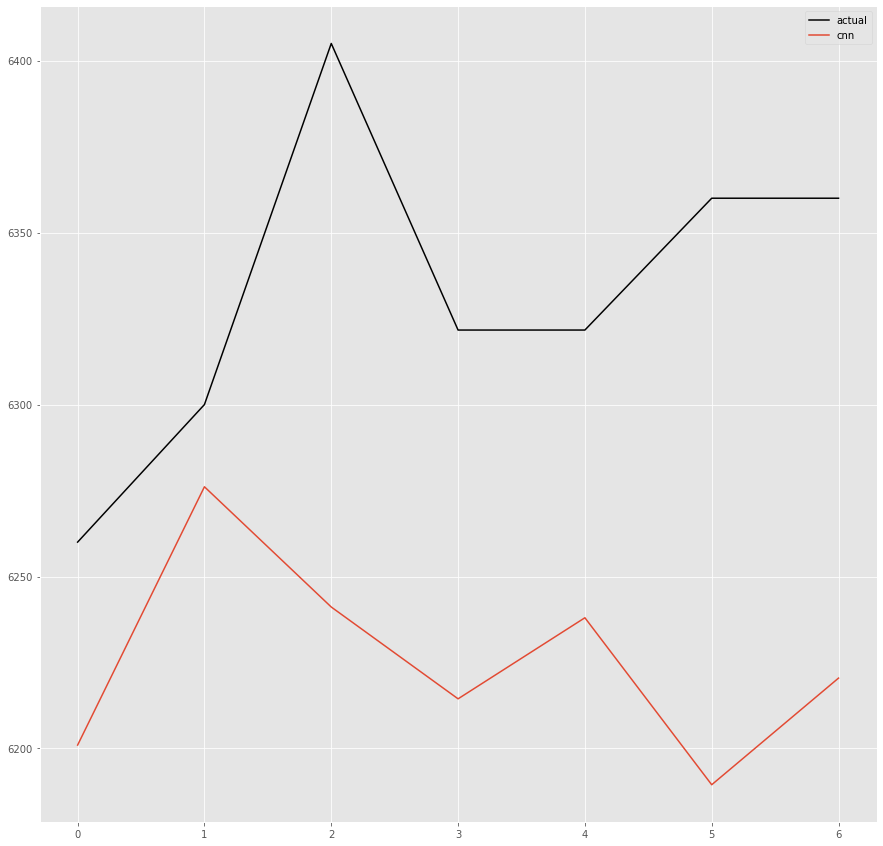

In [81]:
# Plot scores
today = dt.date.today()
week_later = today + dt.timedelta(days = 7)
date = pd.to_datetime(week_later)

plt.figure(figsize = (15,15))

plt.plot(test[:,:,0][0],
         label = 'actual', 
         color = 'black')

plt.plot(predictions_bbca[0], 
         label = 'cnn')

plt.legend()
plt.show()

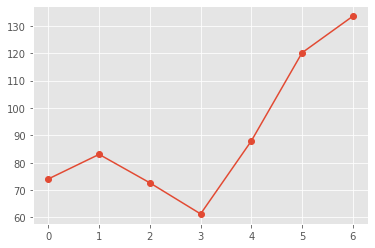

In [82]:
# Plot scores
plt.plot(scores_bbca, 
         marker = 'o', 
         label = 'cnn')

plt.show()

# Forecasting

**Note**: In this analytics, the prediction and forecasting will only performed on the 'conventional', which is the ARIMA, ARIMAX, and SARIMA model, and will not be performed on the GARCH model.

## Prediction

### ARIMA(3,1,1)

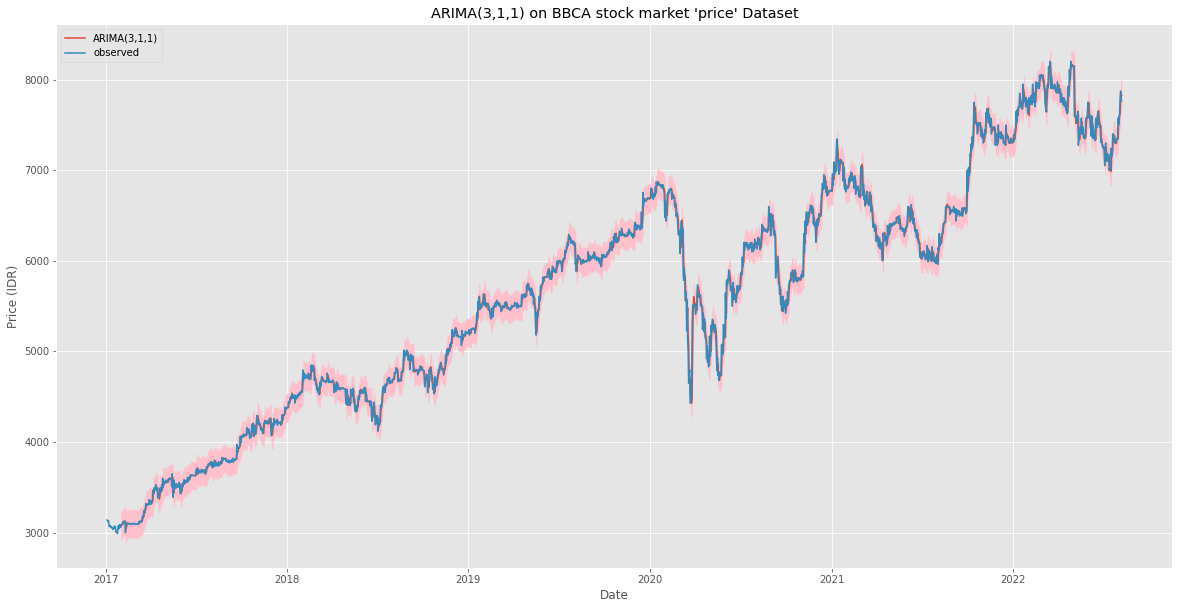

In [83]:
# ARIMA(3,1,1)

# Create ARIMA(3,1,1) mean forecast
arima_pred_1_bbca = results_1_bbca.get_prediction(start = '2017-02-01')
arima_mean_1_bbca = arima_pred_1_bbca.predicted_mean

# Get confidence intervals of ARIMA(3,1,1) mean forecasts
conf_int_arima_1_bbca = arima_pred_1_bbca.conf_int()

# Plot mean ARIMA predictions and observed
plt.figure(figsize = (20,10))

plt.plot(arima_mean_1_bbca.index, 
         arima_mean_1_bbca, 
         label = 'ARIMA(3,1,1)')

plt.fill_between(conf_int_arima_1_bbca.index, 
                 conf_int_arima_1_bbca['lower close'], 
                 conf_int_arima_1_bbca['upper close'], 
                 color = 'pink')

plt.plot(bbca_info['2017-01-04':], 
         label = 'observed')

plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.title('ARIMA(3,1,1) on BBCA stock market \'price\' Dataset')
plt.legend()
plt.show()

### ARIMAX(3,1,1,'IDR/USD')

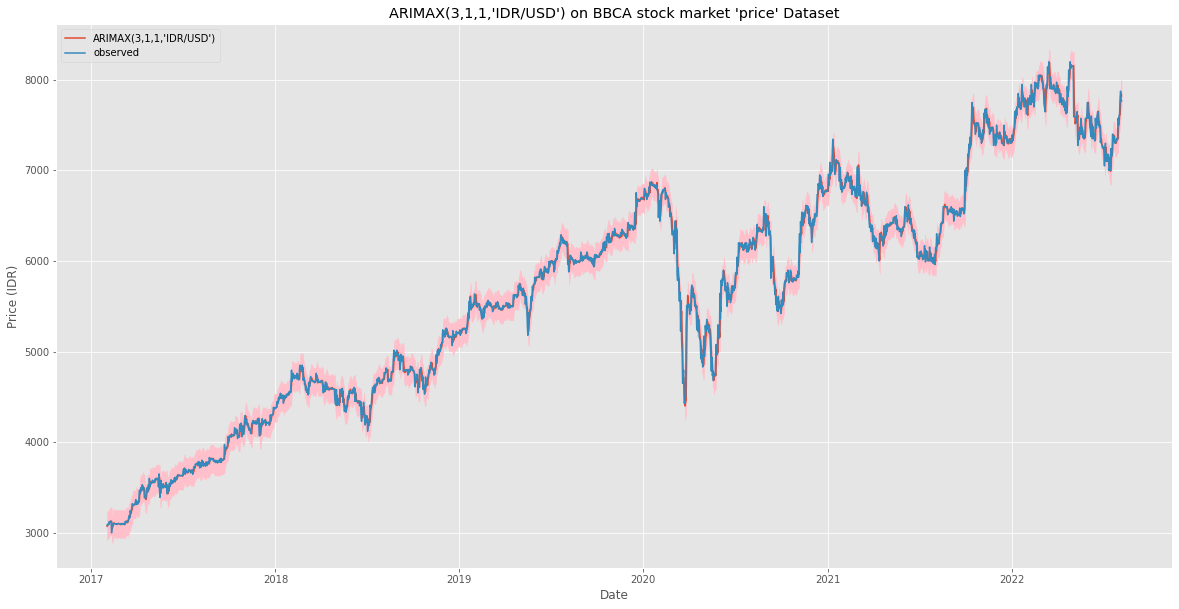

In [84]:
# ARIMAX(3,1,1,'IDR/USD')

# Create ARIMAX(3,1,1,'IDR/USD') mean forecast
arima_pred_2_bbca = results_2_bbca.get_prediction(start = '2017-02-01')
arima_mean_2_bbca = arima_pred_2_bbca.predicted_mean

# Get confidence intervals of ARIMAX(3,1,1,'IDR/USD') mean forecasts
conf_int_arima_2_bbca = arima_pred_2_bbca.conf_int()

# Plot mean ARIMAX predictions and observed
plt.figure(figsize = (20,10))

plt.plot(arima_mean_2_bbca.index, 
         arima_mean_2_bbca, 
         label = 'ARIMAX(3,1,1,\'IDR/USD\')')

plt.fill_between(conf_int_arima_2_bbca.index, 
                 conf_int_arima_2_bbca['lower close'], 
                 conf_int_arima_2_bbca['upper close'],
                 color = 'pink')

plt.plot(bbca_info['2017-02-01':], 
         label = 'observed')

plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.title('ARIMAX(3,1,1,\'IDR/USD\') on BBCA stock market \'price\' Dataset')
plt.legend()
plt.show()

### SARIMA(3,1,1)

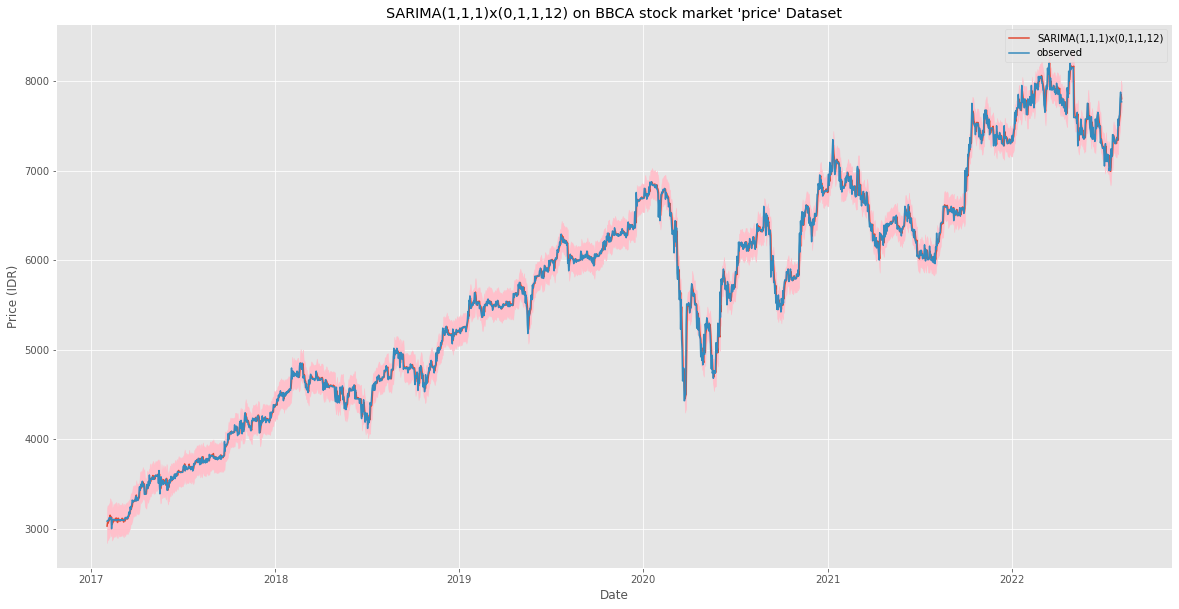

In [85]:
# SARIMA(1,1,1)x(0,1,1,12)

# Create SARIMA(1,1,1)x(0,1,1,12) mean forecast
arima_pred_3_bbca = results_3_bbca.get_prediction(start = '2017-02-01')
arima_mean_3_bbca = arima_pred_3_bbca.predicted_mean

# Get confidence intervals of SARIMA(1,1,1)x(0,1,1,12) mean forecasts
conf_int_arima_3_bbca = arima_pred_3_bbca.conf_int()

# Plot mean ARIMAX predictions and observed
plt.figure(figsize = (20,10))

plt.plot(arima_mean_3_bbca.index, 
         arima_mean_3_bbca, 
         label = 'SARIMA(1,1,1)x(0,1,1,12)')

plt.fill_between(conf_int_arima_3_bbca.index, 
                 conf_int_arima_3_bbca['lower close'], 
                 conf_int_arima_3_bbca['upper close'],
                 color = 'pink')

plt.plot(bbca_info['2017-02-01':], 
         label = 'observed')

plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.title('SARIMA(1,1,1)x(0,1,1,12) on BBCA stock market \'price\' Dataset')
plt.legend()
plt.show()

## RMSE

In [86]:
y_bbca = bbca_info['2017-01-04':]

# Prediction for all models
yhat_1_bbca = results_1_bbca.get_prediction(start = '2017-01-04').predicted_mean
yhat_2_bbca = results_2_bbca.get_prediction(start = '2017-01-04').predicted_mean
yhat_3_bbca = results_3_bbca.get_prediction(start = '2017-01-04').predicted_mean
# yhat_4_bbca = results_4_bbca.get_prediction(start = '2017-01-04').predicted_mean

# Print MSE
print("MSE for ARIMA(3,1,1) prediction : ", mean_squared_error(y_bbca, yhat_1_bbca))
print("MSE for ARIMAX(1,1,1,'IDR/USD') prediction : ", mean_squared_error(y_bbca, yhat_2_bbca))
print("MSE for SARIMA(3,1,1) prediction : ", mean_squared_error(y_bbca, yhat_3_bbca))
# print("MSE for GARCH(1,1) prediction : ", mean_squared_error(y_bbca, yhat_4_bbca))

MSE for ARIMA(3,1,1) prediction :  6124.943841533274
MSE for ARIMAX(1,1,1,'IDR/USD') prediction :  6087.039499229485
MSE for SARIMA(3,1,1) prediction :  8526.895750266518


## Model Summary

In [87]:
# Cetak Root Mean Square
rmse_1 = np.sqrt(mean_squared_error(y_bbca, yhat_1_bbca))
rmse_2 = np.sqrt(mean_squared_error(y_bbca, yhat_2_bbca))
rmse_3 = np.sqrt(mean_squared_error(y_bbca, yhat_3_bbca))
# rmse_4 = np.sqrt(mean_squared_error(y_bbca, yhat_4_bbca))
rmse_5 = score_bbca

rmse = [rmse_1, rmse_2, rmse_3, rmse_5]

# Cetak Nama Model
model = ['ARIMA(3,1,1)', 'ARIMAX(3,1,1,\'IDR/USD\')', 'SARIMA(1,1,1)x(0,1,1,12)', 'CNN']

# Buat dictionary
dict_data_bbca = {'Nama Model': model,
                  'RMSE' : rmse}

# Buat DataFramenya
df_score_bbca = pd.DataFrame(dict_data_bbca).sort_values(by = 'RMSE', 
                                                         ascending = True).reset_index(drop = True)

df_score_bbca

,Nama Model,RMSE
0,"ARIMAX(3,1,1,'IDR/USD')",78.019482
1,"ARIMA(3,1,1)",78.262020
2,"SARIMA(1,1,1)x(0,1,1,12)",92.341192
3,CNN,93.680219


### Final Best Model

Based on the AIC-BIC, Diagnostic Test, and also the RMSE results, we can conclude that:

1. SARIMA(3,1,1)
2. ARIMAX(3,1,1,'IDR/USD')
3. ARIMA(3,1,1) 

respectively, are the **best models** for our BBCA dataset since they are **statistically significance** and have the **lowest AIC-BIC** and **lowest RMSE**.

We will see the forecasted result for each models.

**Note**: ARIMA and ARIMAX model have lower AIC-BIC and RMSE, but their coefficients are not statistically significant, unlike SARIMA model.

## Forecasting

In [88]:
def forecast_time_series(data, model_result, n_steps, predicted_date, exog = None, exog_name = None, result = False):
    arimax_pred = model_result.get_forecast(steps = n_steps,
                                            # A week is chosen as forecasting for a long term 
                                            # is not wise and will certainly lead to a high bias/low confidence level
                                            exog = exog_idr_usd[-1:-n_steps-1:-1], 
                                            dynamic = True)

    arimax_mean = pd.DataFrame(arimax_pred.predicted_mean)
    arimax_mean.index = predicted_date
    arimax_mean.columns = ['close']

    arimax_mean = pd.concat([data, arimax_mean], axis = 0)

    # Get confidence intervals of ARIMAX(1,1,0,'IDR/USD') mean forecasts
    conf_int_arimax = arimax_pred.conf_int()
    conf_int_arimax.index = predicted_date


    if result == False:
        # Plot mean ARIMAX predictions and observed
        plt.figure(figsize = (20,10))

        plt.plot(arimax_mean[start_date:], 
                 label = f'Prediction ARIMAX(3,1,1,{exog_name}))', 
                 color = 'red')

        plt.fill_between(conf_int_arimax.index, 
                         conf_int_arimax['lower close'], 
                         conf_int_arimax['upper close'], 
                         label = None,
                         color = 'pink')

        plt.plot(data[start_date:], 
                 label = 'observed', 
                 color = 'blue')

        plt.xlabel('Date')
        plt.ylabel('Price (IDR)')
        plt.title(f'ARIMAX(3,1,1,{exog_name}) on BBCA stock market prediction \'price\' in the next 7 days')
        plt.legend()
        plt.show()
        pass
        
    else:
        conf_int_arimax['close'] = arimax_mean['close'][-n_steps::1]
        conf_int_arimax = conf_int_arimax[['lower close', 'close', 'upper close']]
        return conf_int_arimax

In [89]:
# Start observing date
start_date = '2021-12-01'

# Start predicted date
predicted_dates = pd.date_range(start = dt.datetime.now().strftime('%Y-%m-%d'), 
                                end = (dt.datetime.now() + dt.timedelta(days = 6)).strftime('%Y-%m-%d'))

### ARIMA(3,1,1)

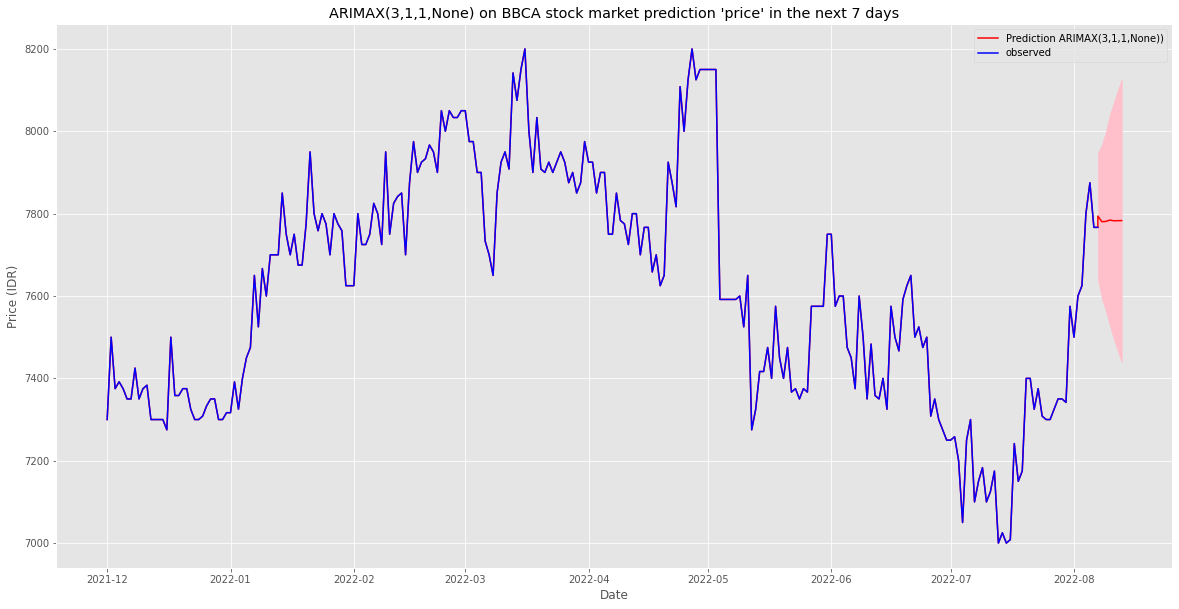

In [90]:
forecast_time_series(data = bbca_info, 
                     model_result = results_1_bbca, 
                     n_steps = 7, 
                     exog = None, 
                     exog_name = None, 
                     predicted_date = predicted_dates, 
                     result = False)

In [91]:
# ARIMA(3,1,1) Prediction
result_1 = forecast_time_series(data = bbca_info, 
                                model_result = results_1_bbca, 
                                n_steps = 7, 
                                exog = None, 
                                exog_name = None, 
                                predicted_date = predicted_dates, 
                                result = True)

result_1

,lower close,close,upper close
2022-08-07,7640.710404,7794.096800,7947.483196
2022-08-08,7593.917723,7780.452770,7966.987817
2022-08-09,7562.852507,7781.103247,7999.353988
2022-08-10,7528.109696,7784.332311,8040.554926
2022-08-11,7495.343217,7782.641193,8069.939170
2022-08-12,7466.503828,7782.809345,8099.114861
2022-08-13,7439.076639,7783.193424,8127.310209


### ARIMAX(3,1,1,'IDR/USD')

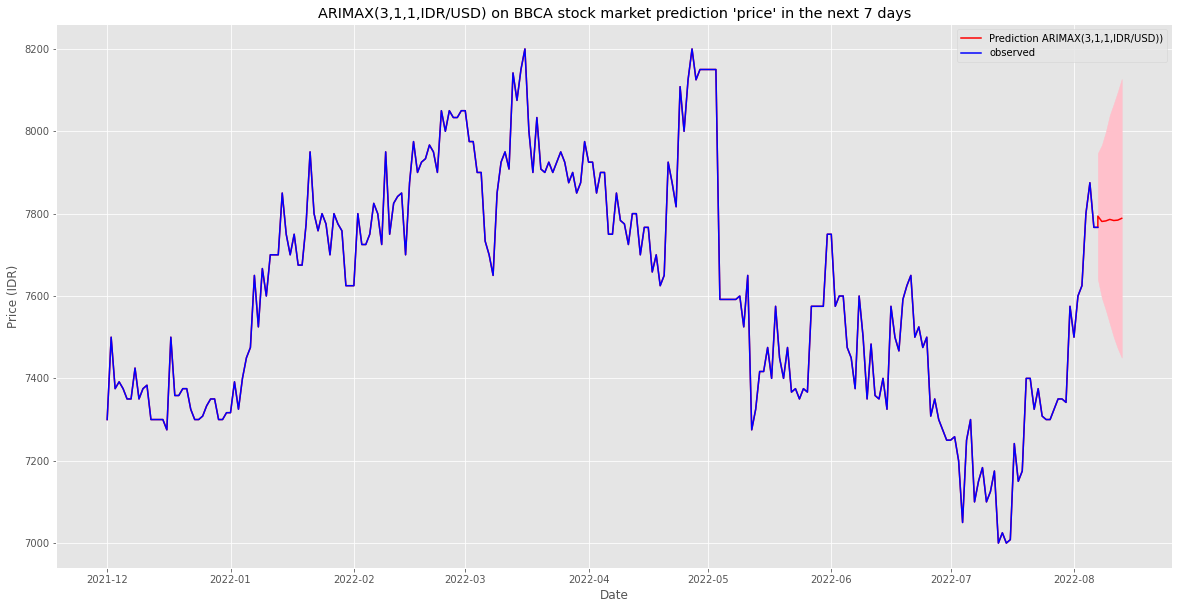

In [92]:
forecast_time_series(data = bbca_info, 
                     model_result = results_2_bbca, 
                     n_steps = 7, 
                     exog = exog_idr_usd, 
                     exog_name = 'IDR/USD', 
                     predicted_date = predicted_dates, 
                     result = False)

In [93]:
# ARIMAX(3,1,1,'IDR/USD') Prediction
result_2 = forecast_time_series(data = bbca_info, 
                                model_result = results_2_bbca, 
                                n_steps = 7, 
                                exog = exog_idr_usd, 
                                exog_name = 'IDR/USD', 
                                predicted_date = predicted_dates, 
                                result = True)

result_2

,lower close,close,upper close
2022-08-07,7641.053821,7793.968506,7946.883192
2022-08-08,7595.744288,7780.992114,7966.239940
2022-08-09,7566.156075,7782.312592,7998.469108
2022-08-10,7533.009220,7785.988674,8038.968129
2022-08-11,7500.153598,7783.290439,8066.427280
2022-08-12,7472.946334,7784.227027,8095.507720
2022-08-13,7450.365242,7788.596016,8126.826791


### SARIMA(1,1,1)x(0,1,1,12)

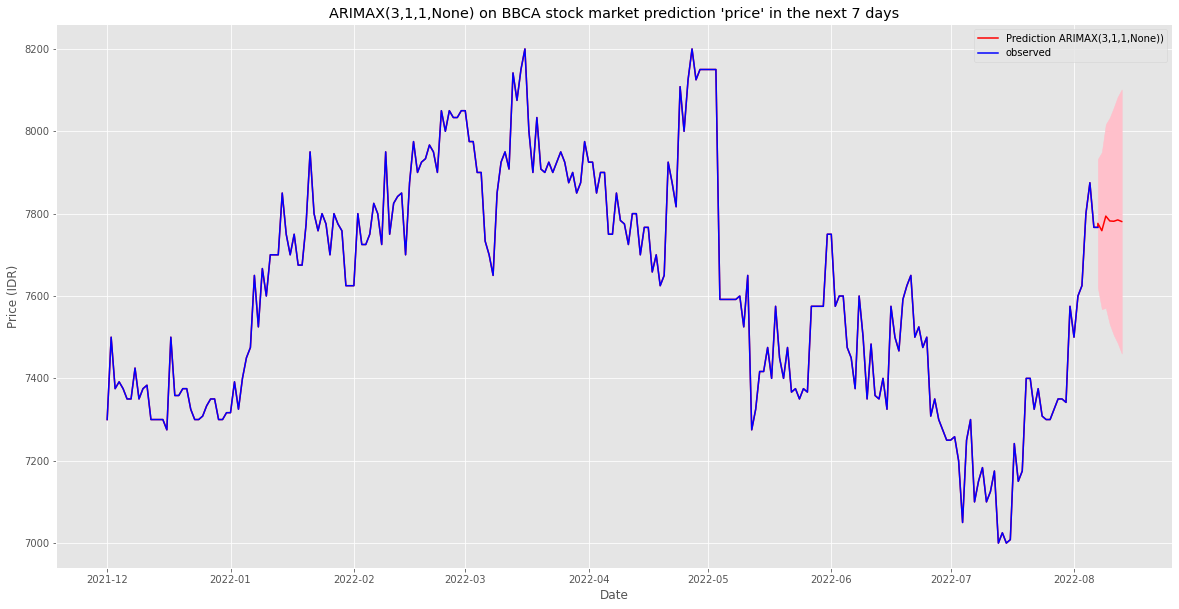

In [94]:
forecast_time_series(data = bbca_info, 
                     model_result = results_3_bbca, 
                     n_steps = 7, 
                     exog = None, 
                     exog_name = None, 
                     predicted_date = predicted_dates, 
                     result = False)

In [95]:
# SARIMA(3,1,1) Prediction
result_3 = forecast_time_series(data = bbca_info, 
                                model_result = results_3_bbca, 
                                n_steps = 7, 
                                exog = None, 
                                exog_name = None, 
                                predicted_date = predicted_dates, 
                                result = True)

result_3

,lower close,close,upper close
2022-08-07,7620.153602,7776.345733,7932.537864
2022-08-08,7568.143744,7758.586531,7949.029319
2022-08-09,7570.984516,7794.039592,8017.094668
2022-08-10,7531.250984,7782.223993,8033.197003
2022-08-11,7505.302040,7781.452891,8057.603742
2022-08-12,7485.559298,7784.767207,8083.975116
2022-08-13,7460.282602,7780.895027,8101.507451


### GARCH(1,1)

In [96]:
# forecast_time_series(data = bbca_info, 
#                      model_result = results_4_bbca, 
#                      n_steps = 7, 
#                      exog = None, 
#                      exog_name = None', 
#                      predicted_date = predicted_dates, 
#                      result = False)

In [97]:
# # GARCH(1,1) Prediction
# result_4 = forecast_time_series(data = bbca_info, 
#                                 model_result = results_4_bbca, 
#                                 n_steps = 7, 
#                                 exog = None, 
#                                 exog_name = None, 
#                                 predicted_date = predicted_dates, 
#                                 result = True)

# result_4

## Conclusion

Notice that even though both ARIMA(3,1,1) and ARIMAX(3,1,1,'IDR/USD') do not showing sign of catching the trend (static). In addition, we also know that their coefficients are not all statistically significants, in contrast with SARIMA model. Thus, we will use the SARIMA(1,1,1)x(0,1,1,12) model as our predictor model.

In [98]:
# weight_1 = 1/3
# weight_2 = 1/3
# weight_3 = 1/3

# Final prediction
weighted_result = result_3
weighted_result

,lower close,close,upper close
2022-08-07,7620.153602,7776.345733,7932.537864
2022-08-08,7568.143744,7758.586531,7949.029319
2022-08-09,7570.984516,7794.039592,8017.094668
2022-08-10,7531.250984,7782.223993,8033.197003
2022-08-11,7505.302040,7781.452891,8057.603742
2022-08-12,7485.559298,7784.767207,8083.975116
2022-08-13,7460.282602,7780.895027,8101.507451


Based on our model, we can see that for the **next 7 days**, we can expect that the **BBCA stock market price** will be have a decrement trend from **7600 IDR to 7450 IDR**, and a **margin error of ~6.3%**.

## Recommendation

**Technical**

---

A better and validated result can probably be obtained by **comparing the model** using more **advance forecasting model**, such as **ARCH/GARCH**. Or even better, a **combined ARIMA-GARCH model**, where we use ARIMA to predict the mean and GARCH to predict the variance of future values.

**Non-technical**

---

The BBCA stock market price do not show any sign of dropping anytime soon. So, if you are a **shareholder**, try **not to sell your stock**, except in case of emergencies. And for a **non-shareholder**, you probably want to **wait** when the price is showing a **decrement trend**, which is **probably** not in the near future (1-week time).

# Bonus: Portfolio Optimization

Since the author is still an Undergraduate student which do not possess a large sum of money, we want to **minimize the risk of losing money**. Thus, here we will optimize our Portfolio by using **Mean Conditional Value at Risk (mCVAR) algorithm**, which works by measuring the worst-case scenarios for each asset in the portfolio, and is represented here by losing the most money.

## Data Preparation

In [99]:
portfolio = pd.DataFrame()

portfolio.index = bbca_info.index

# Get BBCA and ^JKSE close value
portfolio['BBCA'] = bbca_info.values
portfolio['^JKSE'] = jkse_info.values

portfolio

,BBCA,^JKSE
date,,
2017-01-03,3155.000000,5275.971191
2017-01-04,3140.000000,5301.183105
2017-01-05,3135.000000,5325.503906
2017-01-06,3120.000000,5347.021973
2017-01-07,3131.666667,5324.569661
...,...,...
2022-08-03,7625.000000,7046.634766
2022-08-04,7800.000000,7057.348145
2022-08-05,7875.000000,7084.654785


## Optimization

In [100]:
mu = mean_historical_return(portfolio)

S = portfolio.cov()

ef_cvar = EfficientCVaR(mu, S)
cvar_weights = ef_cvar.min_cvar()

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))

{'BBCA': 1.0, '^JKSE': 0.0}


In [101]:
# Get the latest value of each stock price
latest_prices = get_latest_prices(portfolio)

# Assuming that we have IDR 5 mio
da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value = 5e6)

allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): IDR {:.2f}".format(leftover))

Discrete allocation (CVAR): {'BBCA': 643}
Funds remaining (CVAR): IDR 6033.34


C:\Users\c640\AppData\Local\Programs\Python\Python310\lib\site-packages\pypfopt\discrete_allocation.py:210: RuntimeWarning: invalid value encountered in divide
  current_weights /= current_weights.sum()


Notice that using this algorithm, we are suggested to perform **all-out invest into BBCA** stockprice. It is logical since BBCA stockprice has an **increment trend and has multiplied 2.5 of its original price since it was first introduced**, and only had one spike drop, which happened during the early COVID-19 pandemic.